In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
# from tqdm.autonotebook import tqdm
from tqdm import tqdm

In [2]:
import torch.optim as optim
from torch.utils import data

In [3]:
from transformers_lib import TransformerBlock, \
        Mixer_TransformerBlock_Encoder, \
        PositionalEncoding

In [4]:
class TinyImageNet_Preload(data.Dataset):
#     https://gist.github.com/z-a-f/b862013c0dc2b540cf96a123a6766e54
    
    def __init__(self, root, mode='train', transform=None, preload=False):
        super().__init__()
        self.preload = preload
        dataset = datasets.ImageFolder(
            root=os.path.join(root, mode),
            transform=None
        )
        self.transform = transform
        self.images, self.labels = [], []
        print("Dataset Size:",len(dataset))
        
        if preload:
            for i in tqdm(range(len(dataset))):
                x, y = dataset[i]
                self.images.append(x)
                self.labels.append(y)
                
#         del dataset
        self.dataset = dataset
            
    def _add_channels(img, total_channels=3):
        while len(img.shape) < 3:  # third axis is the channels
            img = np.expand_dims(img, axis=-1)
        while(img.shape[-1]) < 3:
            img = np.concatenate([img, img[:, :, -1:]], axis=-1)
        return img
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if self.preload:
            img, lbl = self.images[idx], self.labels[idx]
        else:
            img, lbl = self.dataset[idx]
        return self.transform(img), lbl

# Model

In [5]:
class Mixer_ViT_Classifier(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_size:tuple, hidden_channel:int, num_blocks:int, num_classes:int, block_seq_size:int, block_mlp_size:int, forward_expansion:float=2.0, pos_emb=True, dropout:float=0.0):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
        ### find patch dim
        d0 = int(image_dim[-2]/patch_size[0])
        d1 = int(image_dim[-1]/patch_size[1])
        assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
        assert d1*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
        
#         self.d0, self.d1 = d0, d1 ### number of patches in each axis
        __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
        ### find channel dim
        channel_size = d0*d1 ## number of patches
        
        ### after the number of channels are changed
        init_dim = __patch_size
        final_dim = hidden_channel
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
        self.channel_change = nn.Linear(init_dim, final_dim)
        print(f"ViT Mixer : Channels per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
        self.channel_dim = final_dim
        self.patch_dim = channel_size
        
        self.transformer_blocks = []
        
        f = self.get_factors(self.channel_dim)
        print(f)
        fi = np.abs(np.array(f) - np.sqrt(self.channel_dim)).argmin()
        
        _n_heads = f[fi]
        
        ## number of dims per channel -> channel_dim
#         print('Num patches:', self.patch_dim)
        print(f'Sequence len: {self.patch_dim} ; Block size: {block_seq_size}')
        print('Channel dim:', self.channel_dim, 'num heads:',_n_heads)
        
        if block_seq_size is None or block_seq_size<2:
            ### Find the block size for sequence:
            block_seq_size = int(2**np.ceil(np.log2(np.sqrt(self.patch_dim))))
            
        print(f'MLP dim: {self.channel_dim} ; Block size: {block_mlp_size}')

        for i in range(num_blocks):
            L = Mixer_TransformerBlock_Encoder(self.patch_dim, block_seq_size, self.channel_dim, _n_heads, dropout, forward_expansion, nn.GELU, block_mlp_size)
            self.transformer_blocks.append(L)
        self.transformer_blocks = nn.Sequential(*self.transformer_blocks)
        
        self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        
        self.positional_encoding = PositionalEncoding(self.channel_dim, dropout=0)
        if not pos_emb:
            self.positional_encoding = nn.Identity()
        
        
    def get_factors(self, n):
        facts = []
        for i in range(2, n+1):
            if n%i == 0:
                facts.append(i)
        return facts
    
    def forward(self, x):
        bs = x.shape[0]
        x = self.unfold(x).swapaxes(-1, -2)
        x = self.channel_change(x)
        x = self.positional_encoding(x)
        x = self.transformer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [6]:
def experiment_skip(model_name, ep):
    if 'sMlp' in model_name:
        return False
    
    filename = f"./output/benchmark/{model_name}_data.json"
    if os.path.exists(filename):
        with open(filename) as f:
            data = json.load(f)
        ## data consists of lists and dicts.
        epochs = data['train_stat'][-1][0]
        if epochs < ep-1:
            return False
    
    return True

In [7]:
def benchmark(dataset:str, patch_size:int, num_layers:int, SEED:int, sparse_att:bool=False, sparse_mlp:bool=False, pos_emb:bool=False, cuda:int=0):
    device = torch.device(f"cuda:{cuda}")
    
    if sparse_att:
        assert num_layers%2 == 0, 'number of blocks on sparse transformer is (x2)/2 hence it must be even'
        num_layers_ = num_layers//2
    else:
        num_layers_ = num_layers
    
    BS = 256
    NC = -1
    EPOCHS = 300
    imsize = (3, 32, 32)
    expansion_dict = {16:1024, 8:256, 4:128, 2:64, 1:64}
    expansion = expansion_dict[patch_size]

    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    ##### Data Transforms
    if dataset == 'tiny':
        NC = 200
        EPOCHS = 400
        imsize = (3, 64, 64)
        tiny_train = transforms.Compose([
        transforms.RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5]*3,
            std=[0.2]*3,
            ),
        ])

        tiny_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5]*3,
                std=[0.2]*3,
            ),
        ])
        
        train_dataset = TinyImageNet_Preload(root="../../../../../_Datasets/tiny-imagenet-200",
                                     mode='train', transform=tiny_train)
        test_dataset = TinyImageNet_Preload(root="../../../../../_Datasets/tiny-imagenet-200",
                                     mode='val', transform=tiny_test)
        
    elif dataset == 'cifar10':
        NC = 10
        BS = 128
        cifar_train = transforms.Compose([
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
                std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
            ),
        ])

        cifar_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
                std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
            ),
        ])

        train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
        test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

    elif dataset == 'cifar100':
        NC = 100
        BS = 128
        cifar_train = transforms.Compose([
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5071, 0.4865, 0.4409],
                std=[0.2009, 0.1984, 0.2023],
            ),
        ])

        cifar_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5071, 0.4865, 0.4409],
                std=[0.2009, 0.1984, 0.2023],
            ),
        ])

        train_dataset = datasets.CIFAR100(root="../../../../../_Datasets/cifar100/", train=True, download=True, transform=cifar_train)
        test_dataset = datasets.CIFAR100(root="../../../../../_Datasets/cifar100/", train=False, download=True, transform=cifar_test)
        
    ##### Now create data loaders
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BS, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BS, shuffle=False, num_workers=4)
    
    ### Now create models
    
    seq_len = (imsize[-1]*imsize[-2])//(patch_size*patch_size)
    mlp_dim = expansion
    print(seq_len, mlp_dim)
    
    if sparse_att:
        seq_len = int(2**np.ceil(np.log2(np.sqrt(seq_len))))
    if sparse_mlp:
        mlp_dim = int(2**np.ceil(np.log2(np.sqrt(expansion))))
    
    
    torch.manual_seed(SEED)
    model = Mixer_ViT_Classifier(imsize, 
                                 patch_size=[patch_size]*2, 
                                 hidden_channel=expansion, 
                                 num_blocks=num_layers_, 
                                 num_classes=NC, 
                                 block_seq_size=seq_len, 
                                 block_mlp_size=mlp_dim,
                                 pos_emb=pos_emb).to(device)
    
#     _x = torch.randn(BS, *imsize).to(device)
#     print("Output: ",vit_mixer(_x).shape)
    num_params = sum(p.numel() for p in model.parameters())
    print("number of params: ", num_params)
    
    _a, _b, _c = 'att', 'mlp', 'nPE'
    if sparse_att: _a = 'sAtt'
    if sparse_mlp: _b = 'sMlp'
    if pos_emb: _c = 'PE'
    model_name = f'01.3_ViT_{_c}_{dataset}_patch{patch_size}_l{num_layers}_{_a}_{_b}_s{SEED}'
    print(f"Model Name: {model_name}")
    
    if experiment_skip(model_name, EPOCHS):
        print(f'EXPERIMENT DONE... SKIPPING : {model_name}')
        return
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    STAT ={'train_stat':[], 'test_stat':[], 'params':num_params, }

    ## Following is copied from 
    ### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

    # Training
    def train(epoch):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
#             break

        STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
        print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
        return

    global best_acc
    best_acc = -1
    def test(epoch):
        global best_acc
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        time_taken = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
                inputs, targets = inputs.to(device), targets.to(device)

                start = time.time()

                outputs = model(inputs)

                start = time.time()-start
                time_taken.append(start)

                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total, np.mean(time_taken))) ### (Epochs, Loss, Acc, time)
        print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")

        # Save checkpoint.
        acc = 100.*correct/total
        if acc > best_acc:
            print('Saving..')
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch
            }
            if not os.path.isdir('models'):
                os.mkdir('models')
            torch.save(state, f'./models/benchmark/{model_name}.pth')
            best_acc = acc

        with open(f"./output/benchmark/{model_name}_data.json", 'w') as f:
            json.dump(STAT, f, indent=0)

    ### Train the whole damn thing
#     EPOCHS = 1
    for epoch in range(0, EPOCHS):
        train(epoch)
        test(epoch)
        scheduler.step()
        
    
    train_stat = np.array(STAT['train_stat'])
    test_stat = np.array(STAT['test_stat'])

    plt.plot(train_stat[:,1], label='train')
    plt.plot(test_stat[:,1], label='test')
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"./output/benchmark/plots/{model_name}_loss.svg")
    plt.show()

    plt.plot(train_stat[:,2], label='train')
    plt.plot(test_stat[:,2], label='test')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"./output/benchmark/plots/{model_name}_accs.svg")
    plt.show()
    
    del model, optimizer
    return

In [8]:
# benchmark(dataset='tiny', 
#           patch_size=4, num_layers=10, SEED=123, sparse_att=True, sparse_mlp=True, cuda=0
#          )

In [9]:
# ### Automate the benchmark
# ###### for tiny
# cuda_idx = 0
# # for seed in [147, 258, 369]:
# for seed in [147]:
#     for patch_size in [16, 8, 4]:
#         for sparse_attention in [False, True]:
#             for sparse_mlp in [False, True]:
# #                 for nlayers in [6, 10, 14]:
#                 for nlayers in [6]:
#                     print(f'''
#                         Experimenting on Tiny Dataset 
#                         patch:{patch_size},
#                         sparse_att: {sparse_attention},
#                         sparse_mlp: {sparse_mlp},
#                         num_layers : {nlayers},
#                         seed: {seed}
#                     ''')
            
#                     benchmark(dataset='tiny', 
#                               patch_size=patch_size, 
#                               num_layers=nlayers, 
#                               SEED=seed, 
#                               sparse_att=sparse_attention, sparse_mlp=sparse_mlp, 
#                               cuda=cuda_idx
#                              )


In [10]:
# ### Automate the benchmark
# ###### for tiny

# not_working = [
#     (4, False, True, 6),
#     (4, False, False, 10),
#     (4, False, False, 14),
#     (4, False, True, 10),
#     (4, False, True, 14),
#     (4, True, True, 14),
# ]

# cuda_idx = 0
# # for seed in [147, 258, 369]:
# for seed in [147]:
#     for patch_size in [16, 8, 4]:
#         for sparse_attention in [False, True]:
#             for sparse_mlp in [False, True]:
#                 for nlayers in [6, 10, 14]:

#                     print(f'''
#                         Experimenting on Tiny Dataset 
#                         patch:{patch_size},
#                         sparse_att: {sparse_attention},
#                         sparse_mlp: {sparse_mlp},
#                         num_layers : {nlayers},
#                         seed: {seed}
#                     ''')
            
#                 ### check if config is in not_working case
#                     exit = False
#                     for nw in not_working:
#                         if patch_size==nw[0] and \
#                             sparse_attention==nw[1] and \
#                             sparse_mlp==nw[2] and\
#                             nlayers==nw[3]:
                            
#                             exit=True
#                             break
#                     if exit:
#                         print(f'Exiting as the config is in NOT WORKING')
#                         continue


#                     benchmark(dataset='tiny', 
#                               patch_size=patch_size, 
#                               num_layers=nlayers, 
#                               SEED=seed, 
#                               sparse_att=sparse_attention, sparse_mlp=sparse_mlp, 
#                               cuda=cuda_idx
#                              )



                                Experimenting on cifar100 Dataset 
                                patch:8,
                                sparse_att: False,
                                sparse_mlp: False,
                                num_layers: 4,
                                pos_embed: True,
                                seed: 147
                            
Files already downloaded and verified
Files already downloaded and verified
16 256
ViT Mixer : Channels per patch -> Initial:192 Final:256
[2, 4, 8, 16, 32, 64, 128, 256]
Sequence len: 16 ; Block size: 16
Channel dim: 256 num heads: 16
MLP dim: 256 ; Block size: 256
number of params:  2567524
Model Name: 01.3_ViT_PE_cifar100_patch8_l4_att_mlp_s147
EXPERIMENT DONE... SKIPPING : 01.3_ViT_PE_cifar100_patch8_l4_att_mlp_s147

                                Experimenting on cifar100 Dataset 
                                patch:8,
                                sparse_att: False,
                                sparse

100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.69it/s]


[Train] 0 Loss: 4.130 | Acc: 7.310 3655/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.62it/s]


[Test] 0 Loss: 3.803 | Acc: 12.220 1222/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.44it/s]


[Train] 1 Loss: 3.673 | Acc: 14.082 7041/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.24it/s]


[Test] 1 Loss: 3.521 | Acc: 17.030 1703/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 2 Loss: 3.467 | Acc: 17.740 8870/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.06it/s]


[Test] 2 Loss: 3.357 | Acc: 19.850 1985/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.32it/s]


[Train] 3 Loss: 3.313 | Acc: 20.656 10328/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.55it/s]


[Test] 3 Loss: 3.228 | Acc: 22.280 2228/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.37it/s]


[Train] 4 Loss: 3.203 | Acc: 22.292 11146/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.76it/s]


[Test] 4 Loss: 3.145 | Acc: 23.960 2396/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.28it/s]


[Train] 5 Loss: 3.106 | Acc: 24.364 12182/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.79it/s]


[Test] 5 Loss: 3.080 | Acc: 25.020 2502/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.38it/s]


[Train] 6 Loss: 3.034 | Acc: 25.666 12833/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.60it/s]


[Test] 6 Loss: 3.023 | Acc: 26.210 2621/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.21it/s]


[Train] 7 Loss: 2.976 | Acc: 26.634 13317/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.89it/s]


[Test] 7 Loss: 2.976 | Acc: 27.350 2735/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 8 Loss: 2.918 | Acc: 27.806 13903/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.58it/s]


[Test] 8 Loss: 2.909 | Acc: 28.420 2842/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 9 Loss: 2.879 | Acc: 28.386 14193/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.37it/s]


[Test] 9 Loss: 2.879 | Acc: 28.940 2894/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 10 Loss: 2.833 | Acc: 29.386 14693/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.45it/s]


[Test] 10 Loss: 2.865 | Acc: 29.800 2980/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.28it/s]


[Train] 11 Loss: 2.789 | Acc: 30.516 15258/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.50it/s]


[Test] 11 Loss: 2.819 | Acc: 30.610 3061/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.21it/s]


[Train] 12 Loss: 2.755 | Acc: 30.854 15427/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.27it/s]


[Test] 12 Loss: 2.807 | Acc: 31.260 3126/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 13 Loss: 2.717 | Acc: 31.716 15858/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.91it/s]


[Test] 13 Loss: 2.797 | Acc: 31.040 3104/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.26it/s]


[Train] 14 Loss: 2.686 | Acc: 32.294 16147/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.12it/s]


[Test] 14 Loss: 2.795 | Acc: 31.310 3131/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 15 Loss: 2.656 | Acc: 33.022 16511/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.96it/s]


[Test] 15 Loss: 2.734 | Acc: 32.440 3244/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.18it/s]


[Train] 16 Loss: 2.630 | Acc: 33.320 16660/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.09it/s]


[Test] 16 Loss: 2.715 | Acc: 32.950 3295/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 17 Loss: 2.597 | Acc: 34.136 17068/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.23it/s]


[Test] 17 Loss: 2.703 | Acc: 33.100 3310/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.22it/s]


[Train] 18 Loss: 2.572 | Acc: 34.460 17230/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.29it/s]


[Test] 18 Loss: 2.689 | Acc: 33.090 3309/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 19 Loss: 2.545 | Acc: 35.420 17710/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.18it/s]


[Test] 19 Loss: 2.686 | Acc: 33.330 3333/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.29it/s]


[Train] 20 Loss: 2.522 | Acc: 35.762 17881/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.97it/s]


[Test] 20 Loss: 2.670 | Acc: 34.240 3424/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.34it/s]


[Train] 21 Loss: 2.501 | Acc: 36.342 18171/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.18it/s]


[Test] 21 Loss: 2.679 | Acc: 34.120 3412/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.24it/s]


[Train] 22 Loss: 2.476 | Acc: 36.604 18302/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.54it/s]


[Test] 22 Loss: 2.657 | Acc: 34.760 3476/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.23it/s]


[Train] 23 Loss: 2.448 | Acc: 37.264 18632/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.75it/s]


[Test] 23 Loss: 2.629 | Acc: 34.680 3468/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.40it/s]


[Train] 24 Loss: 2.428 | Acc: 37.616 18808/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.68it/s]


[Test] 24 Loss: 2.622 | Acc: 34.920 3492/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.68it/s]


[Train] 25 Loss: 2.405 | Acc: 37.816 18908/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.88it/s]


[Test] 25 Loss: 2.626 | Acc: 35.040 3504/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 26 Loss: 2.386 | Acc: 38.272 19136/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.62it/s]


[Test] 26 Loss: 2.625 | Acc: 35.120 3512/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.40it/s]


[Train] 27 Loss: 2.361 | Acc: 39.032 19516/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.71it/s]


[Test] 27 Loss: 2.604 | Acc: 35.700 3570/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 28 Loss: 2.346 | Acc: 39.440 19720/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.55it/s]


[Test] 28 Loss: 2.598 | Acc: 35.200 3520/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 29 Loss: 2.327 | Acc: 39.496 19748/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.81it/s]


[Test] 29 Loss: 2.577 | Acc: 36.340 3634/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.23it/s]


[Train] 30 Loss: 2.312 | Acc: 39.892 19946/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.93it/s]


[Test] 30 Loss: 2.600 | Acc: 35.380 3538/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 31 Loss: 2.285 | Acc: 40.412 20206/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.65it/s]


[Test] 31 Loss: 2.580 | Acc: 35.970 3597/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 32 Loss: 2.269 | Acc: 40.886 20443/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.54it/s]


[Test] 32 Loss: 2.573 | Acc: 35.730 3573/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.13it/s]


[Train] 33 Loss: 2.248 | Acc: 41.294 20647/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.84it/s]


[Test] 33 Loss: 2.557 | Acc: 36.710 3671/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 34 Loss: 2.241 | Acc: 41.600 20800/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.50it/s]


[Test] 34 Loss: 2.570 | Acc: 36.210 3621/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 35 Loss: 2.215 | Acc: 42.012 21006/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.25it/s]


[Test] 35 Loss: 2.570 | Acc: 36.500 3650/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 36 Loss: 2.200 | Acc: 42.284 21142/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.26it/s]


[Test] 36 Loss: 2.557 | Acc: 36.650 3665/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 37 Loss: 2.183 | Acc: 42.644 21322/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.52it/s]


[Test] 37 Loss: 2.545 | Acc: 37.220 3722/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 38 Loss: 2.171 | Acc: 42.986 21493/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.36it/s]


[Test] 38 Loss: 2.551 | Acc: 37.140 3714/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 39 Loss: 2.146 | Acc: 43.622 21811/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.44it/s]


[Test] 39 Loss: 2.554 | Acc: 36.560 3656/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 40 Loss: 2.130 | Acc: 43.924 21962/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.37it/s]


[Test] 40 Loss: 2.553 | Acc: 36.970 3697/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 41 Loss: 2.117 | Acc: 44.084 22042/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.03it/s]


[Test] 41 Loss: 2.525 | Acc: 37.910 3791/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 42 Loss: 2.104 | Acc: 44.346 22173/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.46it/s]


[Test] 42 Loss: 2.539 | Acc: 37.380 3738/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 43 Loss: 2.086 | Acc: 44.814 22407/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.53it/s]


[Test] 43 Loss: 2.542 | Acc: 37.630 3763/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 44 Loss: 2.068 | Acc: 45.264 22632/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.50it/s]


[Test] 44 Loss: 2.540 | Acc: 37.530 3753/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 45 Loss: 2.060 | Acc: 45.052 22526/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.79it/s]


[Test] 45 Loss: 2.552 | Acc: 37.090 3709/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 46 Loss: 2.043 | Acc: 45.866 22933/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.38it/s]


[Test] 46 Loss: 2.554 | Acc: 37.300 3730/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.90it/s]


[Train] 47 Loss: 2.033 | Acc: 46.244 23122/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.34it/s]


[Test] 47 Loss: 2.533 | Acc: 37.710 3771/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 48 Loss: 2.010 | Acc: 46.532 23266/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.97it/s]


[Test] 48 Loss: 2.531 | Acc: 37.960 3796/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 49 Loss: 2.010 | Acc: 46.538 23269/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.51it/s]


[Test] 49 Loss: 2.548 | Acc: 37.660 3766/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.90it/s]


[Train] 50 Loss: 1.997 | Acc: 46.690 23345/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.89it/s]


[Test] 50 Loss: 2.551 | Acc: 37.910 3791/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 51 Loss: 1.976 | Acc: 47.280 23640/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.90it/s]


[Test] 51 Loss: 2.541 | Acc: 37.400 3740/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 52 Loss: 1.962 | Acc: 47.344 23672/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.80it/s]


[Test] 52 Loss: 2.527 | Acc: 38.020 3802/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 53 Loss: 1.953 | Acc: 47.828 23914/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.66it/s]


[Test] 53 Loss: 2.548 | Acc: 37.870 3787/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.23it/s]


[Train] 54 Loss: 1.933 | Acc: 47.948 23974/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.03it/s]


[Test] 54 Loss: 2.542 | Acc: 38.060 3806/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 55 Loss: 1.929 | Acc: 48.294 24147/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.39it/s]


[Test] 55 Loss: 2.530 | Acc: 38.820 3882/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 56 Loss: 1.910 | Acc: 48.624 24312/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.59it/s]


[Test] 56 Loss: 2.544 | Acc: 38.340 3834/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 57 Loss: 1.901 | Acc: 48.920 24460/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.48it/s]


[Test] 57 Loss: 2.531 | Acc: 38.220 3822/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 58 Loss: 1.886 | Acc: 49.122 24561/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.37it/s]


[Test] 58 Loss: 2.539 | Acc: 37.710 3771/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 59 Loss: 1.872 | Acc: 49.606 24803/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.28it/s]


[Test] 59 Loss: 2.517 | Acc: 38.490 3849/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.25it/s]


[Train] 60 Loss: 1.864 | Acc: 49.792 24896/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.34it/s]


[Test] 60 Loss: 2.540 | Acc: 38.040 3804/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 61 Loss: 1.847 | Acc: 49.798 24899/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.58it/s]


[Test] 61 Loss: 2.533 | Acc: 38.570 3857/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 62 Loss: 1.830 | Acc: 50.274 25137/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.05it/s]


[Test] 62 Loss: 2.541 | Acc: 38.570 3857/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 63 Loss: 1.825 | Acc: 50.574 25287/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.41it/s]


[Test] 63 Loss: 2.555 | Acc: 37.660 3766/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.23it/s]


[Train] 64 Loss: 1.814 | Acc: 50.820 25410/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.01it/s]


[Test] 64 Loss: 2.552 | Acc: 38.510 3851/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 65 Loss: 1.807 | Acc: 51.058 25529/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.29it/s]


[Test] 65 Loss: 2.558 | Acc: 38.400 3840/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 66 Loss: 1.791 | Acc: 51.456 25728/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.23it/s]


[Test] 66 Loss: 2.559 | Acc: 38.150 3815/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.94it/s]


[Train] 67 Loss: 1.784 | Acc: 51.592 25796/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.59it/s]


[Test] 67 Loss: 2.568 | Acc: 38.320 3832/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 68 Loss: 1.769 | Acc: 51.684 25842/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.40it/s]


[Test] 68 Loss: 2.547 | Acc: 38.470 3847/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 69 Loss: 1.765 | Acc: 51.842 25921/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.16it/s]


[Test] 69 Loss: 2.561 | Acc: 38.280 3828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 70 Loss: 1.752 | Acc: 52.384 26192/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.40it/s]


[Test] 70 Loss: 2.576 | Acc: 38.250 3825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 71 Loss: 1.739 | Acc: 52.328 26164/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.64it/s]


[Test] 71 Loss: 2.556 | Acc: 38.440 3844/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 72 Loss: 1.726 | Acc: 52.836 26418/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.81it/s]


[Test] 72 Loss: 2.564 | Acc: 38.610 3861/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 73 Loss: 1.716 | Acc: 53.050 26525/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.19it/s]


[Test] 73 Loss: 2.574 | Acc: 38.270 3827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 74 Loss: 1.704 | Acc: 53.538 26769/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.71it/s]


[Test] 74 Loss: 2.569 | Acc: 38.690 3869/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 75 Loss: 1.695 | Acc: 53.766 26883/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.90it/s]


[Test] 75 Loss: 2.565 | Acc: 38.510 3851/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 76 Loss: 1.683 | Acc: 53.836 26918/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.16it/s]


[Test] 76 Loss: 2.579 | Acc: 38.190 3819/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 77 Loss: 1.673 | Acc: 54.042 27021/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.06it/s]


[Test] 77 Loss: 2.565 | Acc: 38.760 3876/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 78 Loss: 1.660 | Acc: 54.626 27313/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.19it/s]


[Test] 78 Loss: 2.588 | Acc: 38.600 3860/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 79 Loss: 1.645 | Acc: 54.974 27487/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.83it/s]


[Test] 79 Loss: 2.569 | Acc: 38.430 3843/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.94it/s]


[Train] 80 Loss: 1.641 | Acc: 55.132 27566/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.89it/s]


[Test] 80 Loss: 2.580 | Acc: 38.560 3856/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 81 Loss: 1.635 | Acc: 54.676 27338/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.92it/s]


[Test] 81 Loss: 2.575 | Acc: 39.070 3907/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 82 Loss: 1.624 | Acc: 55.208 27604/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.71it/s]


[Test] 82 Loss: 2.586 | Acc: 38.680 3868/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 83 Loss: 1.617 | Acc: 55.336 27668/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.93it/s]


[Test] 83 Loss: 2.594 | Acc: 38.470 3847/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 84 Loss: 1.606 | Acc: 55.742 27871/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.83it/s]


[Test] 84 Loss: 2.603 | Acc: 38.780 3878/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.73it/s]


[Train] 85 Loss: 1.597 | Acc: 55.932 27966/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.63it/s]


[Test] 85 Loss: 2.617 | Acc: 38.870 3887/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 86 Loss: 1.592 | Acc: 56.192 28096/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.88it/s]


[Test] 86 Loss: 2.589 | Acc: 38.940 3894/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 87 Loss: 1.575 | Acc: 56.494 28247/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.35it/s]


[Test] 87 Loss: 2.594 | Acc: 38.930 3893/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 88 Loss: 1.565 | Acc: 56.534 28267/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.53it/s]


[Test] 88 Loss: 2.627 | Acc: 38.980 3898/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 89 Loss: 1.559 | Acc: 56.816 28408/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.15it/s]


[Test] 89 Loss: 2.608 | Acc: 38.450 3845/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 90 Loss: 1.548 | Acc: 57.182 28591/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.66it/s]


[Test] 90 Loss: 2.634 | Acc: 38.570 3857/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 91 Loss: 1.530 | Acc: 57.458 28729/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.48it/s]


[Test] 91 Loss: 2.615 | Acc: 38.760 3876/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.13it/s]


[Train] 92 Loss: 1.527 | Acc: 57.756 28878/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.10it/s]


[Test] 92 Loss: 2.622 | Acc: 38.150 3815/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 93 Loss: 1.528 | Acc: 57.770 28885/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.02it/s]


[Test] 93 Loss: 2.607 | Acc: 39.160 3916/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.87it/s]


[Train] 94 Loss: 1.513 | Acc: 58.126 29063/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.43it/s]


[Test] 94 Loss: 2.627 | Acc: 39.010 3901/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.85it/s]


[Train] 95 Loss: 1.502 | Acc: 58.322 29161/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.82it/s]


[Test] 95 Loss: 2.617 | Acc: 39.130 3913/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 96 Loss: 1.503 | Acc: 58.302 29151/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.76it/s]


[Test] 96 Loss: 2.642 | Acc: 38.550 3855/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.73it/s]


[Train] 97 Loss: 1.486 | Acc: 58.672 29336/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.04it/s]


[Test] 97 Loss: 2.640 | Acc: 39.060 3906/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.94it/s]


[Train] 98 Loss: 1.484 | Acc: 58.778 29389/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.94it/s]


[Test] 98 Loss: 2.643 | Acc: 39.040 3904/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 99 Loss: 1.467 | Acc: 59.058 29529/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.97it/s]


[Test] 99 Loss: 2.645 | Acc: 38.860 3886/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 100 Loss: 1.466 | Acc: 58.886 29443/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.20it/s]


[Test] 100 Loss: 2.663 | Acc: 38.640 3864/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 101 Loss: 1.464 | Acc: 59.186 29593/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.51it/s]


[Test] 101 Loss: 2.639 | Acc: 38.780 3878/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 102 Loss: 1.441 | Acc: 59.694 29847/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.77it/s]


[Test] 102 Loss: 2.644 | Acc: 38.820 3882/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.79it/s]


[Train] 103 Loss: 1.435 | Acc: 59.750 29875/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.78it/s]


[Test] 103 Loss: 2.644 | Acc: 39.070 3907/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 104 Loss: 1.423 | Acc: 60.072 30036/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.67it/s]


[Test] 104 Loss: 2.677 | Acc: 38.280 3828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 105 Loss: 1.428 | Acc: 60.082 30041/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.24it/s]


[Test] 105 Loss: 2.679 | Acc: 38.840 3884/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 106 Loss: 1.415 | Acc: 60.236 30118/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.93it/s]


[Test] 106 Loss: 2.672 | Acc: 38.700 3870/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 107 Loss: 1.405 | Acc: 60.422 30211/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.95it/s]


[Test] 107 Loss: 2.676 | Acc: 38.720 3872/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 108 Loss: 1.406 | Acc: 60.492 30246/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.02it/s]


[Test] 108 Loss: 2.694 | Acc: 38.520 3852/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.72it/s]


[Train] 109 Loss: 1.389 | Acc: 60.706 30353/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.26it/s]


[Test] 109 Loss: 2.676 | Acc: 38.590 3859/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 110 Loss: 1.388 | Acc: 60.898 30449/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.18it/s]


[Test] 110 Loss: 2.676 | Acc: 39.160 3916/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 111 Loss: 1.371 | Acc: 61.502 30751/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.68it/s]


[Test] 111 Loss: 2.704 | Acc: 38.460 3846/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.82it/s]


[Train] 112 Loss: 1.369 | Acc: 61.440 30720/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.13it/s]


[Test] 112 Loss: 2.712 | Acc: 38.500 3850/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 113 Loss: 1.364 | Acc: 61.472 30736/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.95it/s]


[Test] 113 Loss: 2.690 | Acc: 38.120 3812/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 114 Loss: 1.348 | Acc: 62.192 31096/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.50it/s]


[Test] 114 Loss: 2.719 | Acc: 38.180 3818/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.83it/s]


[Train] 115 Loss: 1.340 | Acc: 62.382 31191/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.45it/s]


[Test] 115 Loss: 2.703 | Acc: 38.950 3895/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 116 Loss: 1.331 | Acc: 62.396 31198/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.13it/s]


[Test] 116 Loss: 2.725 | Acc: 38.590 3859/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.18it/s]


[Train] 117 Loss: 1.338 | Acc: 62.144 31072/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.09it/s]


[Test] 117 Loss: 2.710 | Acc: 39.030 3903/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 118 Loss: 1.323 | Acc: 62.704 31352/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.79it/s]


[Test] 118 Loss: 2.708 | Acc: 38.550 3855/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 119 Loss: 1.318 | Acc: 62.596 31298/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.60it/s]


[Test] 119 Loss: 2.730 | Acc: 38.540 3854/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 120 Loss: 1.315 | Acc: 62.876 31438/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.50it/s]


[Test] 120 Loss: 2.723 | Acc: 38.760 3876/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.64it/s]


[Train] 121 Loss: 1.301 | Acc: 63.238 31619/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.23it/s]


[Test] 121 Loss: 2.719 | Acc: 38.970 3897/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 122 Loss: 1.298 | Acc: 63.354 31677/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.19it/s]


[Test] 122 Loss: 2.729 | Acc: 38.670 3867/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 123 Loss: 1.294 | Acc: 63.340 31670/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.89it/s]


[Test] 123 Loss: 2.725 | Acc: 38.480 3848/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 124 Loss: 1.288 | Acc: 63.414 31707/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.66it/s]


[Test] 124 Loss: 2.734 | Acc: 38.670 3867/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.18it/s]


[Train] 125 Loss: 1.277 | Acc: 63.712 31856/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.82it/s]


[Test] 125 Loss: 2.730 | Acc: 38.620 3862/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.81it/s]


[Train] 126 Loss: 1.262 | Acc: 64.092 32046/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.84it/s]


[Test] 126 Loss: 2.749 | Acc: 38.860 3886/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 127 Loss: 1.258 | Acc: 64.188 32094/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.62it/s]


[Test] 127 Loss: 2.743 | Acc: 38.690 3869/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.80it/s]


[Train] 128 Loss: 1.256 | Acc: 64.382 32191/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.46it/s]


[Test] 128 Loss: 2.729 | Acc: 39.000 3900/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.69it/s]


[Train] 129 Loss: 1.249 | Acc: 64.600 32300/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.60it/s]


[Test] 129 Loss: 2.763 | Acc: 38.880 3888/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 130 Loss: 1.242 | Acc: 64.776 32388/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.49it/s]


[Test] 130 Loss: 2.744 | Acc: 38.800 3880/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 131 Loss: 1.235 | Acc: 64.880 32440/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.25it/s]


[Test] 131 Loss: 2.763 | Acc: 38.940 3894/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 132 Loss: 1.228 | Acc: 65.000 32500/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.08it/s]


[Test] 132 Loss: 2.766 | Acc: 38.850 3885/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 133 Loss: 1.219 | Acc: 65.478 32739/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.88it/s]


[Test] 133 Loss: 2.772 | Acc: 38.660 3866/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 134 Loss: 1.217 | Acc: 65.136 32568/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.20it/s]


[Test] 134 Loss: 2.783 | Acc: 38.630 3863/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 135 Loss: 1.213 | Acc: 65.300 32650/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.84it/s]


[Test] 135 Loss: 2.777 | Acc: 38.490 3849/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.10it/s]


[Train] 136 Loss: 1.203 | Acc: 65.650 32825/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.85it/s]


[Test] 136 Loss: 2.791 | Acc: 38.790 3879/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 137 Loss: 1.197 | Acc: 65.856 32928/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.47it/s]


[Test] 137 Loss: 2.787 | Acc: 38.700 3870/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 138 Loss: 1.185 | Acc: 66.132 33066/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.14it/s]


[Test] 138 Loss: 2.790 | Acc: 38.490 3849/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 139 Loss: 1.188 | Acc: 66.054 33027/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.13it/s]


[Test] 139 Loss: 2.786 | Acc: 38.900 3890/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 140 Loss: 1.182 | Acc: 66.214 33107/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.86it/s]


[Test] 140 Loss: 2.803 | Acc: 38.570 3857/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 141 Loss: 1.168 | Acc: 66.306 33153/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.31it/s]


[Test] 141 Loss: 2.797 | Acc: 38.440 3844/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 142 Loss: 1.166 | Acc: 66.650 33325/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.04it/s]


[Test] 142 Loss: 2.802 | Acc: 38.620 3862/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.90it/s]


[Train] 143 Loss: 1.163 | Acc: 66.802 33401/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.34it/s]


[Test] 143 Loss: 2.807 | Acc: 38.800 3880/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.74it/s]


[Train] 144 Loss: 1.158 | Acc: 66.988 33494/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.96it/s]


[Test] 144 Loss: 2.813 | Acc: 38.880 3888/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.94it/s]


[Train] 145 Loss: 1.147 | Acc: 67.350 33675/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.42it/s]


[Test] 145 Loss: 2.811 | Acc: 38.690 3869/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 146 Loss: 1.140 | Acc: 67.078 33539/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.31it/s]


[Test] 146 Loss: 2.815 | Acc: 38.320 3832/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 147 Loss: 1.132 | Acc: 67.914 33957/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.48it/s]


[Test] 147 Loss: 2.828 | Acc: 38.820 3882/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 148 Loss: 1.134 | Acc: 67.764 33882/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.78it/s]


[Test] 148 Loss: 2.825 | Acc: 38.500 3850/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 149 Loss: 1.129 | Acc: 67.742 33871/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.03it/s]


[Test] 149 Loss: 2.828 | Acc: 38.470 3847/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 150 Loss: 1.126 | Acc: 67.626 33813/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.45it/s]


[Test] 150 Loss: 2.837 | Acc: 38.330 3833/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 151 Loss: 1.120 | Acc: 67.906 33953/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.14it/s]


[Test] 151 Loss: 2.840 | Acc: 38.560 3856/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 152 Loss: 1.116 | Acc: 67.810 33905/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.52it/s]


[Test] 152 Loss: 2.857 | Acc: 38.340 3834/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 153 Loss: 1.107 | Acc: 68.140 34070/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.48it/s]


[Test] 153 Loss: 2.840 | Acc: 38.340 3834/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 154 Loss: 1.099 | Acc: 68.494 34247/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.98it/s]


[Test] 154 Loss: 2.849 | Acc: 38.390 3839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 155 Loss: 1.105 | Acc: 68.336 34168/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.02it/s]


[Test] 155 Loss: 2.860 | Acc: 38.680 3868/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 156 Loss: 1.088 | Acc: 68.668 34334/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.23it/s]


[Test] 156 Loss: 2.858 | Acc: 38.620 3862/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.79it/s]


[Train] 157 Loss: 1.090 | Acc: 68.622 34311/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.01it/s]


[Test] 157 Loss: 2.849 | Acc: 38.830 3883/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 158 Loss: 1.081 | Acc: 68.944 34472/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.51it/s]


[Test] 158 Loss: 2.849 | Acc: 38.450 3845/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.13it/s]


[Train] 159 Loss: 1.076 | Acc: 69.306 34653/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.47it/s]


[Test] 159 Loss: 2.856 | Acc: 38.720 3872/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 160 Loss: 1.074 | Acc: 69.152 34576/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.47it/s]


[Test] 160 Loss: 2.867 | Acc: 38.250 3825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 161 Loss: 1.064 | Acc: 69.416 34708/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.45it/s]


[Test] 161 Loss: 2.872 | Acc: 38.840 3884/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 162 Loss: 1.066 | Acc: 69.354 34677/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.02it/s]


[Test] 162 Loss: 2.884 | Acc: 38.730 3873/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 163 Loss: 1.053 | Acc: 69.932 34966/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.20it/s]


[Test] 163 Loss: 2.882 | Acc: 38.830 3883/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 164 Loss: 1.051 | Acc: 69.908 34954/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.11it/s]


[Test] 164 Loss: 2.894 | Acc: 38.350 3835/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.82it/s]


[Train] 165 Loss: 1.048 | Acc: 70.064 35032/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.66it/s]


[Test] 165 Loss: 2.881 | Acc: 38.460 3846/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.83it/s]


[Train] 166 Loss: 1.044 | Acc: 69.720 34860/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.91it/s]


[Test] 166 Loss: 2.887 | Acc: 38.530 3853/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.13it/s]


[Train] 167 Loss: 1.042 | Acc: 69.942 34971/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.05it/s]


[Test] 167 Loss: 2.896 | Acc: 38.380 3838/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.72it/s]


[Train] 168 Loss: 1.040 | Acc: 70.178 35089/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.97it/s]


[Test] 168 Loss: 2.888 | Acc: 38.500 3850/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.83it/s]


[Train] 169 Loss: 1.030 | Acc: 70.298 35149/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.14it/s]


[Test] 169 Loss: 2.900 | Acc: 38.430 3843/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 170 Loss: 1.026 | Acc: 70.370 35185/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.05it/s]


[Test] 170 Loss: 2.896 | Acc: 38.750 3875/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 171 Loss: 1.020 | Acc: 70.720 35360/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.20it/s]


[Test] 171 Loss: 2.910 | Acc: 38.670 3867/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 172 Loss: 1.014 | Acc: 70.796 35398/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.44it/s]


[Test] 172 Loss: 2.900 | Acc: 38.770 3877/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.79it/s]


[Train] 173 Loss: 1.014 | Acc: 70.780 35390/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.66it/s]


[Test] 173 Loss: 2.909 | Acc: 38.590 3859/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 174 Loss: 1.010 | Acc: 70.762 35381/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.27it/s]


[Test] 174 Loss: 2.910 | Acc: 38.630 3863/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 175 Loss: 1.001 | Acc: 71.034 35517/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.50it/s]


[Test] 175 Loss: 2.924 | Acc: 38.260 3826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 176 Loss: 0.996 | Acc: 71.188 35594/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.87it/s]


[Test] 176 Loss: 2.918 | Acc: 38.850 3885/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 177 Loss: 0.992 | Acc: 71.312 35656/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.08it/s]


[Test] 177 Loss: 2.925 | Acc: 38.600 3860/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 178 Loss: 0.990 | Acc: 71.564 35782/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.76it/s]


[Test] 178 Loss: 2.939 | Acc: 38.550 3855/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.72it/s]


[Train] 179 Loss: 0.984 | Acc: 71.614 35807/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.15it/s]


[Test] 179 Loss: 2.921 | Acc: 38.320 3832/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 180 Loss: 0.983 | Acc: 71.704 35852/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.88it/s]


[Test] 180 Loss: 2.935 | Acc: 38.290 3829/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 181 Loss: 0.981 | Acc: 71.682 35841/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.82it/s]


[Test] 181 Loss: 2.943 | Acc: 38.140 3814/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.21it/s]


[Train] 182 Loss: 0.979 | Acc: 71.436 35718/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.56it/s]


[Test] 182 Loss: 2.946 | Acc: 38.220 3822/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.78it/s]


[Train] 183 Loss: 0.969 | Acc: 71.928 35964/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.34it/s]


[Test] 183 Loss: 2.952 | Acc: 38.260 3826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 184 Loss: 0.964 | Acc: 71.952 35976/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.88it/s]


[Test] 184 Loss: 2.946 | Acc: 38.320 3832/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.13it/s]


[Train] 185 Loss: 0.961 | Acc: 72.494 36247/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.44it/s]


[Test] 185 Loss: 2.958 | Acc: 38.090 3809/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.79it/s]


[Train] 186 Loss: 0.966 | Acc: 72.316 36158/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.51it/s]


[Test] 186 Loss: 2.961 | Acc: 38.680 3868/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 187 Loss: 0.957 | Acc: 72.348 36174/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.50it/s]


[Test] 187 Loss: 2.959 | Acc: 38.410 3841/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 188 Loss: 0.954 | Acc: 72.188 36094/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.48it/s]


[Test] 188 Loss: 2.959 | Acc: 38.750 3875/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 189 Loss: 0.957 | Acc: 72.102 36051/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.10it/s]


[Test] 189 Loss: 2.964 | Acc: 38.560 3856/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.16it/s]


[Train] 190 Loss: 0.944 | Acc: 72.580 36290/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.97it/s]


[Test] 190 Loss: 2.966 | Acc: 38.460 3846/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.10it/s]


[Train] 191 Loss: 0.941 | Acc: 72.634 36317/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.58it/s]


[Test] 191 Loss: 2.955 | Acc: 38.660 3866/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 192 Loss: 0.940 | Acc: 72.958 36479/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.35it/s]


[Test] 192 Loss: 2.969 | Acc: 38.640 3864/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 193 Loss: 0.932 | Acc: 73.158 36579/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.54it/s]


[Test] 193 Loss: 2.971 | Acc: 38.390 3839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.10it/s]


[Train] 194 Loss: 0.933 | Acc: 73.078 36539/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.48it/s]


[Test] 194 Loss: 2.975 | Acc: 38.250 3825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 195 Loss: 0.924 | Acc: 73.444 36722/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.46it/s]


[Test] 195 Loss: 2.978 | Acc: 38.110 3811/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.81it/s]


[Train] 196 Loss: 0.922 | Acc: 73.474 36737/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.76it/s]


[Test] 196 Loss: 2.984 | Acc: 38.240 3824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 197 Loss: 0.923 | Acc: 73.418 36709/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.38it/s]


[Test] 197 Loss: 2.978 | Acc: 38.660 3866/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 198 Loss: 0.913 | Acc: 73.652 36826/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.74it/s]


[Test] 198 Loss: 2.984 | Acc: 38.780 3878/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 199 Loss: 0.915 | Acc: 73.672 36836/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.75it/s]


[Test] 199 Loss: 2.994 | Acc: 38.550 3855/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.94it/s]


[Train] 200 Loss: 0.909 | Acc: 73.598 36799/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.24it/s]


[Test] 200 Loss: 2.989 | Acc: 38.700 3870/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 201 Loss: 0.911 | Acc: 73.648 36824/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.62it/s]


[Test] 201 Loss: 2.995 | Acc: 38.600 3860/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 202 Loss: 0.901 | Acc: 73.978 36989/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.10it/s]


[Test] 202 Loss: 2.991 | Acc: 38.570 3857/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.18it/s]


[Train] 203 Loss: 0.901 | Acc: 74.036 37018/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.06it/s]


[Test] 203 Loss: 2.995 | Acc: 38.480 3848/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.79it/s]


[Train] 204 Loss: 0.900 | Acc: 73.948 36974/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.77it/s]


[Test] 204 Loss: 2.995 | Acc: 38.410 3841/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.85it/s]


[Train] 205 Loss: 0.893 | Acc: 74.086 37043/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.82it/s]


[Test] 205 Loss: 3.006 | Acc: 38.530 3853/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 206 Loss: 0.890 | Acc: 74.366 37183/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.52it/s]


[Test] 206 Loss: 3.008 | Acc: 38.080 3808/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 207 Loss: 0.896 | Acc: 73.964 36982/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.06it/s]


[Test] 207 Loss: 3.007 | Acc: 38.210 3821/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 208 Loss: 0.886 | Acc: 74.422 37211/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.27it/s]


[Test] 208 Loss: 3.003 | Acc: 38.270 3827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 209 Loss: 0.891 | Acc: 74.434 37217/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.16it/s]


[Test] 209 Loss: 3.008 | Acc: 38.350 3835/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 210 Loss: 0.880 | Acc: 74.602 37301/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.32it/s]


[Test] 210 Loss: 3.019 | Acc: 38.370 3837/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 211 Loss: 0.878 | Acc: 74.552 37276/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.98it/s]


[Test] 211 Loss: 3.025 | Acc: 38.480 3848/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.83it/s]


[Train] 212 Loss: 0.882 | Acc: 74.544 37272/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.39it/s]


[Test] 212 Loss: 3.019 | Acc: 38.300 3830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.10it/s]


[Train] 213 Loss: 0.874 | Acc: 74.780 37390/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.35it/s]


[Test] 213 Loss: 3.016 | Acc: 38.390 3839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 214 Loss: 0.873 | Acc: 74.854 37427/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.30it/s]


[Test] 214 Loss: 3.016 | Acc: 38.410 3841/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 215 Loss: 0.877 | Acc: 74.416 37208/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.53it/s]


[Test] 215 Loss: 3.024 | Acc: 38.370 3837/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.85it/s]


[Train] 216 Loss: 0.864 | Acc: 74.972 37486/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.78it/s]


[Test] 216 Loss: 3.033 | Acc: 38.420 3842/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 217 Loss: 0.861 | Acc: 75.166 37583/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.04it/s]


[Test] 217 Loss: 3.029 | Acc: 38.340 3834/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 218 Loss: 0.861 | Acc: 75.040 37520/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.68it/s]


[Test] 218 Loss: 3.029 | Acc: 38.270 3827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 219 Loss: 0.857 | Acc: 75.230 37615/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.16it/s]


[Test] 219 Loss: 3.035 | Acc: 38.220 3822/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 220 Loss: 0.861 | Acc: 75.004 37502/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.75it/s]


[Test] 220 Loss: 3.024 | Acc: 38.450 3845/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.78it/s]


[Train] 221 Loss: 0.858 | Acc: 74.990 37495/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.35it/s]


[Test] 221 Loss: 3.033 | Acc: 38.450 3845/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 222 Loss: 0.849 | Acc: 75.424 37712/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.86it/s]


[Test] 222 Loss: 3.029 | Acc: 38.350 3835/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 223 Loss: 0.846 | Acc: 75.524 37762/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.21it/s]


[Test] 223 Loss: 3.033 | Acc: 38.240 3824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 224 Loss: 0.843 | Acc: 75.592 37796/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.55it/s]


[Test] 224 Loss: 3.034 | Acc: 38.260 3826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 225 Loss: 0.854 | Acc: 75.060 37530/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.26it/s]


[Test] 225 Loss: 3.038 | Acc: 38.230 3823/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 226 Loss: 0.844 | Acc: 75.620 37810/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.95it/s]


[Test] 226 Loss: 3.038 | Acc: 38.240 3824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 227 Loss: 0.848 | Acc: 75.414 37707/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.88it/s]


[Test] 227 Loss: 3.042 | Acc: 38.320 3832/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 228 Loss: 0.846 | Acc: 75.398 37699/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.10it/s]


[Test] 228 Loss: 3.037 | Acc: 38.260 3826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 229 Loss: 0.837 | Acc: 75.774 37887/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.74it/s]


[Test] 229 Loss: 3.037 | Acc: 38.200 3820/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 230 Loss: 0.839 | Acc: 75.940 37970/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.61it/s]


[Test] 230 Loss: 3.044 | Acc: 38.220 3822/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.76it/s]


[Train] 231 Loss: 0.839 | Acc: 75.764 37882/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.94it/s]


[Test] 231 Loss: 3.042 | Acc: 38.170 3817/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 232 Loss: 0.839 | Acc: 75.620 37810/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.90it/s]


[Test] 232 Loss: 3.039 | Acc: 38.210 3821/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 233 Loss: 0.837 | Acc: 75.920 37960/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.10it/s]


[Test] 233 Loss: 3.040 | Acc: 38.360 3836/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.77it/s]


[Train] 234 Loss: 0.832 | Acc: 75.956 37978/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.07it/s]


[Test] 234 Loss: 3.051 | Acc: 38.380 3838/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 235 Loss: 0.827 | Acc: 76.008 38004/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.71it/s]


[Test] 235 Loss: 3.043 | Acc: 38.220 3822/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.90it/s]


[Train] 236 Loss: 0.826 | Acc: 76.232 38116/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.94it/s]


[Test] 236 Loss: 3.048 | Acc: 38.410 3841/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 237 Loss: 0.826 | Acc: 76.130 38065/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.21it/s]


[Test] 237 Loss: 3.045 | Acc: 38.330 3833/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.26it/s]


[Train] 238 Loss: 0.817 | Acc: 76.328 38164/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.90it/s]


[Test] 238 Loss: 3.047 | Acc: 38.210 3821/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 239 Loss: 0.826 | Acc: 76.158 38079/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.03it/s]


[Test] 239 Loss: 3.050 | Acc: 38.220 3822/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.21it/s]


[Train] 240 Loss: 0.823 | Acc: 76.134 38067/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.41it/s]


[Test] 240 Loss: 3.051 | Acc: 38.230 3823/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.79it/s]


[Train] 241 Loss: 0.823 | Acc: 76.272 38136/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.15it/s]


[Test] 241 Loss: 3.058 | Acc: 38.320 3832/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.87it/s]


[Train] 242 Loss: 0.818 | Acc: 76.424 38212/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.64it/s]


[Test] 242 Loss: 3.051 | Acc: 38.320 3832/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 243 Loss: 0.815 | Acc: 76.550 38275/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.71it/s]


[Test] 243 Loss: 3.055 | Acc: 38.350 3835/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 244 Loss: 0.806 | Acc: 76.788 38394/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.58it/s]


[Test] 244 Loss: 3.049 | Acc: 37.930 3793/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 245 Loss: 0.814 | Acc: 76.532 38266/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.81it/s]


[Test] 245 Loss: 3.055 | Acc: 38.240 3824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 246 Loss: 0.809 | Acc: 76.752 38376/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.77it/s]


[Test] 246 Loss: 3.060 | Acc: 38.450 3845/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 247 Loss: 0.804 | Acc: 76.834 38417/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.89it/s]


[Test] 247 Loss: 3.056 | Acc: 38.310 3831/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.90it/s]


[Train] 248 Loss: 0.808 | Acc: 76.738 38369/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.97it/s]


[Test] 248 Loss: 3.057 | Acc: 38.360 3836/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 249 Loss: 0.809 | Acc: 76.462 38231/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.54it/s]


[Test] 249 Loss: 3.052 | Acc: 38.180 3818/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 250 Loss: 0.803 | Acc: 76.920 38460/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.19it/s]


[Test] 250 Loss: 3.055 | Acc: 38.210 3821/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 251 Loss: 0.804 | Acc: 76.694 38347/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.95it/s]


[Test] 251 Loss: 3.057 | Acc: 38.280 3828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.81it/s]


[Train] 252 Loss: 0.800 | Acc: 76.962 38481/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.83it/s]


[Test] 252 Loss: 3.059 | Acc: 38.380 3838/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 253 Loss: 0.805 | Acc: 76.962 38481/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.99it/s]


[Test] 253 Loss: 3.062 | Acc: 38.150 3815/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.71it/s]


[Train] 254 Loss: 0.796 | Acc: 77.108 38554/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.29it/s]


[Test] 254 Loss: 3.061 | Acc: 38.280 3828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 255 Loss: 0.802 | Acc: 76.928 38464/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.06it/s]


[Test] 255 Loss: 3.061 | Acc: 38.480 3848/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 256 Loss: 0.798 | Acc: 77.068 38534/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.06it/s]


[Test] 256 Loss: 3.061 | Acc: 38.210 3821/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 257 Loss: 0.797 | Acc: 77.058 38529/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.35it/s]


[Test] 257 Loss: 3.063 | Acc: 38.340 3834/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 258 Loss: 0.799 | Acc: 77.088 38544/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.92it/s]


[Test] 258 Loss: 3.065 | Acc: 38.390 3839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 259 Loss: 0.797 | Acc: 77.070 38535/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.65it/s]


[Test] 259 Loss: 3.066 | Acc: 38.320 3832/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 260 Loss: 0.795 | Acc: 77.006 38503/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.94it/s]


[Test] 260 Loss: 3.064 | Acc: 38.460 3846/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 261 Loss: 0.793 | Acc: 77.030 38515/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.25it/s]


[Test] 261 Loss: 3.063 | Acc: 38.430 3843/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 262 Loss: 0.789 | Acc: 77.342 38671/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.82it/s]


[Test] 262 Loss: 3.062 | Acc: 38.260 3826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 263 Loss: 0.798 | Acc: 77.000 38500/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.96it/s]


[Test] 263 Loss: 3.063 | Acc: 38.280 3828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.75it/s]


[Train] 264 Loss: 0.792 | Acc: 77.400 38700/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.14it/s]


[Test] 264 Loss: 3.064 | Acc: 38.250 3825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.26it/s]


[Train] 265 Loss: 0.795 | Acc: 77.108 38554/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.03it/s]


[Test] 265 Loss: 3.066 | Acc: 38.270 3827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.75it/s]


[Train] 266 Loss: 0.791 | Acc: 77.368 38684/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.90it/s]


[Test] 266 Loss: 3.068 | Acc: 38.130 3813/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 267 Loss: 0.789 | Acc: 77.530 38765/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.92it/s]


[Test] 267 Loss: 3.066 | Acc: 38.370 3837/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 268 Loss: 0.795 | Acc: 76.784 38392/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.11it/s]


[Test] 268 Loss: 3.066 | Acc: 38.480 3848/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 269 Loss: 0.790 | Acc: 77.226 38613/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.04it/s]


[Test] 269 Loss: 3.067 | Acc: 38.500 3850/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 270 Loss: 0.785 | Acc: 77.394 38697/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.63it/s]


[Test] 270 Loss: 3.066 | Acc: 38.390 3839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.71it/s]


[Train] 271 Loss: 0.793 | Acc: 77.074 38537/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.05it/s]


[Test] 271 Loss: 3.066 | Acc: 38.390 3839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.87it/s]


[Train] 272 Loss: 0.787 | Acc: 77.154 38577/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.83it/s]


[Test] 272 Loss: 3.066 | Acc: 38.350 3835/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 273 Loss: 0.784 | Acc: 77.482 38741/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.04it/s]


[Test] 273 Loss: 3.065 | Acc: 38.410 3841/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.90it/s]


[Train] 274 Loss: 0.787 | Acc: 77.502 38751/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.24it/s]


[Test] 274 Loss: 3.066 | Acc: 38.390 3839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 275 Loss: 0.787 | Acc: 77.324 38662/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.60it/s]


[Test] 275 Loss: 3.067 | Acc: 38.440 3844/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.78it/s]


[Train] 276 Loss: 0.785 | Acc: 77.406 38703/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.02it/s]


[Test] 276 Loss: 3.067 | Acc: 38.300 3830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.87it/s]


[Train] 277 Loss: 0.786 | Acc: 77.348 38674/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.69it/s]


[Test] 277 Loss: 3.068 | Acc: 38.360 3836/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 278 Loss: 0.786 | Acc: 77.408 38704/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.88it/s]


[Test] 278 Loss: 3.067 | Acc: 38.380 3838/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 279 Loss: 0.783 | Acc: 77.580 38790/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.35it/s]


[Test] 279 Loss: 3.067 | Acc: 38.450 3845/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 280 Loss: 0.786 | Acc: 77.548 38774/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.34it/s]


[Test] 280 Loss: 3.068 | Acc: 38.310 3831/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.79it/s]


[Train] 281 Loss: 0.783 | Acc: 77.682 38841/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.97it/s]


[Test] 281 Loss: 3.068 | Acc: 38.380 3838/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 282 Loss: 0.792 | Acc: 77.164 38582/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.16it/s]


[Test] 282 Loss: 3.069 | Acc: 38.370 3837/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 283 Loss: 0.784 | Acc: 77.496 38748/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.90it/s]


[Test] 283 Loss: 3.068 | Acc: 38.340 3834/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 284 Loss: 0.783 | Acc: 77.574 38787/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.34it/s]


[Test] 284 Loss: 3.068 | Acc: 38.340 3834/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.10it/s]


[Train] 285 Loss: 0.788 | Acc: 77.502 38751/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.69it/s]


[Test] 285 Loss: 3.068 | Acc: 38.380 3838/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 286 Loss: 0.788 | Acc: 77.410 38705/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.72it/s]


[Test] 286 Loss: 3.069 | Acc: 38.340 3834/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.83it/s]


[Train] 287 Loss: 0.793 | Acc: 77.108 38554/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.83it/s]


[Test] 287 Loss: 3.068 | Acc: 38.400 3840/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.76it/s]


[Train] 288 Loss: 0.777 | Acc: 77.682 38841/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.08it/s]


[Test] 288 Loss: 3.068 | Acc: 38.370 3837/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.83it/s]


[Train] 289 Loss: 0.778 | Acc: 77.844 38922/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.63it/s]


[Test] 289 Loss: 3.069 | Acc: 38.410 3841/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 290 Loss: 0.784 | Acc: 77.606 38803/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.22it/s]


[Test] 290 Loss: 3.068 | Acc: 38.390 3839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.16it/s]


[Train] 291 Loss: 0.782 | Acc: 77.692 38846/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.98it/s]


[Test] 291 Loss: 3.068 | Acc: 38.340 3834/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 292 Loss: 0.778 | Acc: 77.584 38792/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.19it/s]


[Test] 292 Loss: 3.068 | Acc: 38.400 3840/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 293 Loss: 0.781 | Acc: 77.618 38809/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.69it/s]


[Test] 293 Loss: 3.069 | Acc: 38.400 3840/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 294 Loss: 0.789 | Acc: 77.242 38621/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.71it/s]


[Test] 294 Loss: 3.068 | Acc: 38.400 3840/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 295 Loss: 0.785 | Acc: 77.346 38673/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.70it/s]


[Test] 295 Loss: 3.068 | Acc: 38.390 3839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.94it/s]


[Train] 296 Loss: 0.775 | Acc: 77.586 38793/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.62it/s]


[Test] 296 Loss: 3.068 | Acc: 38.410 3841/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 297 Loss: 0.777 | Acc: 77.830 38915/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.41it/s]


[Test] 297 Loss: 3.068 | Acc: 38.400 3840/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.16it/s]


[Train] 298 Loss: 0.779 | Acc: 77.506 38753/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.96it/s]


[Test] 298 Loss: 3.068 | Acc: 38.400 3840/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 299 Loss: 0.779 | Acc: 77.532 38766/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.55it/s]


[Test] 299 Loss: 3.068 | Acc: 38.400 3840/10000


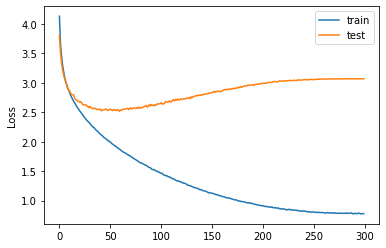

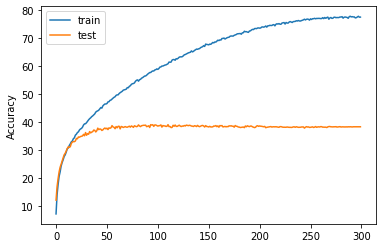


                                Experimenting on cifar100 Dataset 
                                patch:8,
                                sparse_att: False,
                                sparse_mlp: True,
                                num_layers: 4,
                                pos_embed: False,
                                seed: 147
                            
Files already downloaded and verified
Files already downloaded and verified
16 256
ViT Mixer : Channels per patch -> Initial:192 Final:256
[2, 4, 8, 16, 32, 64, 128, 256]
Sequence len: 16 ; Block size: 16
Channel dim: 256 num heads: 16
MLP dim: 256 ; Block size: 16
number of params:  1653092
Model Name: 01.3_ViT_nPE_cifar100_patch8_l4_att_sMlp_s147


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 0 Loss: 4.078 | Acc: 8.210 4105/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.83it/s]


[Test] 0 Loss: 3.805 | Acc: 12.480 1248/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 1 Loss: 3.648 | Acc: 14.714 7357/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.24it/s]


[Test] 1 Loss: 3.511 | Acc: 17.410 1741/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.13it/s]


[Train] 2 Loss: 3.418 | Acc: 18.454 9227/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.46it/s]


[Test] 2 Loss: 3.392 | Acc: 19.470 1947/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.18it/s]


[Train] 3 Loss: 3.267 | Acc: 21.250 10625/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.29it/s]


[Test] 3 Loss: 3.208 | Acc: 23.090 2309/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.25it/s]


[Train] 4 Loss: 3.167 | Acc: 22.986 11493/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.68it/s]


[Test] 4 Loss: 3.147 | Acc: 24.450 2445/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 5 Loss: 3.078 | Acc: 24.650 12325/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.84it/s]


[Test] 5 Loss: 3.056 | Acc: 26.140 2614/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.22it/s]


[Train] 6 Loss: 3.007 | Acc: 26.110 13055/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.94it/s]


[Test] 6 Loss: 2.972 | Acc: 27.450 2745/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 7 Loss: 2.947 | Acc: 27.198 13599/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.04it/s]


[Test] 7 Loss: 2.959 | Acc: 27.990 2799/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 8 Loss: 2.884 | Acc: 28.370 14185/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.19it/s]


[Test] 8 Loss: 2.881 | Acc: 28.660 2866/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 9 Loss: 2.843 | Acc: 29.114 14557/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.50it/s]


[Test] 9 Loss: 2.870 | Acc: 29.740 2974/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.82it/s]


[Train] 10 Loss: 2.801 | Acc: 30.198 15099/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.87it/s]


[Test] 10 Loss: 2.830 | Acc: 30.510 3051/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 11 Loss: 2.758 | Acc: 30.958 15479/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.20it/s]


[Test] 11 Loss: 2.783 | Acc: 30.800 3080/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.28it/s]


[Train] 12 Loss: 2.717 | Acc: 31.472 15736/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.45it/s]


[Test] 12 Loss: 2.743 | Acc: 32.100 3210/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.18it/s]


[Train] 13 Loss: 2.680 | Acc: 32.444 16222/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.87it/s]


[Test] 13 Loss: 2.732 | Acc: 32.450 3245/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.10it/s]


[Train] 14 Loss: 2.647 | Acc: 32.876 16438/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.20it/s]


[Test] 14 Loss: 2.706 | Acc: 32.820 3282/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 15 Loss: 2.614 | Acc: 33.718 16859/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.90it/s]


[Test] 15 Loss: 2.698 | Acc: 32.520 3252/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 16 Loss: 2.580 | Acc: 34.216 17108/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.08it/s]


[Test] 16 Loss: 2.667 | Acc: 33.390 3339/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.24it/s]


[Train] 17 Loss: 2.548 | Acc: 35.108 17554/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.79it/s]


[Test] 17 Loss: 2.634 | Acc: 34.230 3423/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.18it/s]


[Train] 18 Loss: 2.520 | Acc: 35.458 17729/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.77it/s]


[Test] 18 Loss: 2.649 | Acc: 34.210 3421/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 19 Loss: 2.492 | Acc: 36.480 18240/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.53it/s]


[Test] 19 Loss: 2.623 | Acc: 34.340 3434/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 20 Loss: 2.477 | Acc: 36.504 18252/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.19it/s]


[Test] 20 Loss: 2.618 | Acc: 35.110 3511/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.23it/s]


[Train] 21 Loss: 2.444 | Acc: 37.228 18614/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.46it/s]


[Test] 21 Loss: 2.612 | Acc: 35.520 3552/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 22 Loss: 2.422 | Acc: 37.690 18845/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.83it/s]


[Test] 22 Loss: 2.591 | Acc: 35.630 3563/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.90it/s]


[Train] 23 Loss: 2.401 | Acc: 37.962 18981/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.67it/s]


[Test] 23 Loss: 2.559 | Acc: 35.950 3595/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 24 Loss: 2.379 | Acc: 38.572 19286/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.28it/s]


[Test] 24 Loss: 2.533 | Acc: 36.480 3648/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.32it/s]


[Train] 25 Loss: 2.355 | Acc: 39.110 19555/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.44it/s]


[Test] 25 Loss: 2.545 | Acc: 36.520 3652/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 26 Loss: 2.339 | Acc: 39.374 19687/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.60it/s]


[Test] 26 Loss: 2.523 | Acc: 36.990 3699/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 27 Loss: 2.318 | Acc: 39.980 19990/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.27it/s]


[Test] 27 Loss: 2.511 | Acc: 37.250 3725/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 28 Loss: 2.296 | Acc: 40.250 20125/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.82it/s]


[Test] 28 Loss: 2.522 | Acc: 36.870 3687/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 29 Loss: 2.274 | Acc: 40.772 20386/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.54it/s]


[Test] 29 Loss: 2.498 | Acc: 37.380 3738/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 30 Loss: 2.260 | Acc: 41.072 20536/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.10it/s]


[Test] 30 Loss: 2.484 | Acc: 37.640 3764/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.27it/s]


[Train] 31 Loss: 2.240 | Acc: 41.512 20756/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.95it/s]


[Test] 31 Loss: 2.485 | Acc: 37.830 3783/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 32 Loss: 2.221 | Acc: 41.900 20950/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.05it/s]


[Test] 32 Loss: 2.490 | Acc: 37.460 3746/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.36it/s]


[Train] 33 Loss: 2.198 | Acc: 42.456 21228/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.38it/s]


[Test] 33 Loss: 2.475 | Acc: 37.700 3770/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 34 Loss: 2.187 | Acc: 42.482 21241/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.76it/s]


[Test] 34 Loss: 2.458 | Acc: 38.670 3867/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 35 Loss: 2.162 | Acc: 42.846 21423/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.84it/s]


[Test] 35 Loss: 2.455 | Acc: 38.390 3839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 36 Loss: 2.156 | Acc: 43.244 21622/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.26it/s]


[Test] 36 Loss: 2.455 | Acc: 38.280 3828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 37 Loss: 2.138 | Acc: 43.528 21764/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.88it/s]


[Test] 37 Loss: 2.438 | Acc: 38.700 3870/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.32it/s]


[Train] 38 Loss: 2.116 | Acc: 44.196 22098/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.40it/s]


[Test] 38 Loss: 2.430 | Acc: 38.940 3894/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 39 Loss: 2.100 | Acc: 44.220 22110/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.60it/s]


[Test] 39 Loss: 2.446 | Acc: 39.010 3901/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 40 Loss: 2.087 | Acc: 44.446 22223/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.59it/s]


[Test] 40 Loss: 2.428 | Acc: 39.260 3926/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 41 Loss: 2.076 | Acc: 45.098 22549/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.27it/s]


[Test] 41 Loss: 2.409 | Acc: 39.880 3988/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.30it/s]


[Train] 42 Loss: 2.066 | Acc: 45.152 22576/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.89it/s]


[Test] 42 Loss: 2.423 | Acc: 39.560 3956/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 43 Loss: 2.037 | Acc: 45.796 22898/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.35it/s]


[Test] 43 Loss: 2.432 | Acc: 38.970 3897/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 44 Loss: 2.031 | Acc: 45.892 22946/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.09it/s]


[Test] 44 Loss: 2.410 | Acc: 39.900 3990/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 45 Loss: 2.019 | Acc: 46.250 23125/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.15it/s]


[Test] 45 Loss: 2.404 | Acc: 39.970 3997/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 46 Loss: 2.001 | Acc: 46.704 23352/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.64it/s]


[Test] 46 Loss: 2.387 | Acc: 40.460 4046/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.22it/s]


[Train] 47 Loss: 1.990 | Acc: 46.968 23484/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.57it/s]


[Test] 47 Loss: 2.416 | Acc: 39.600 3960/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 48 Loss: 1.974 | Acc: 47.192 23596/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.62it/s]


[Test] 48 Loss: 2.410 | Acc: 39.860 3986/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.16it/s]


[Train] 49 Loss: 1.968 | Acc: 47.544 23772/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.44it/s]


[Test] 49 Loss: 2.408 | Acc: 39.720 3972/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 50 Loss: 1.947 | Acc: 47.772 23886/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.35it/s]


[Test] 50 Loss: 2.428 | Acc: 40.280 4028/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.28it/s]


[Train] 51 Loss: 1.932 | Acc: 48.282 24141/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.94it/s]


[Test] 51 Loss: 2.392 | Acc: 40.250 4025/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 52 Loss: 1.925 | Acc: 48.436 24218/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.54it/s]


[Test] 52 Loss: 2.415 | Acc: 40.180 4018/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 53 Loss: 1.905 | Acc: 49.012 24506/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.46it/s]


[Test] 53 Loss: 2.410 | Acc: 40.200 4020/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 54 Loss: 1.898 | Acc: 48.820 24410/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.16it/s]


[Test] 54 Loss: 2.398 | Acc: 40.260 4026/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 55 Loss: 1.884 | Acc: 49.348 24674/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.04it/s]


[Test] 55 Loss: 2.399 | Acc: 40.700 4070/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 56 Loss: 1.870 | Acc: 49.510 24755/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.27it/s]


[Test] 56 Loss: 2.403 | Acc: 40.620 4062/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.27it/s]


[Train] 57 Loss: 1.865 | Acc: 49.436 24718/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.93it/s]


[Test] 57 Loss: 2.403 | Acc: 40.490 4049/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.10it/s]


[Train] 58 Loss: 1.845 | Acc: 50.078 25039/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.39it/s]


[Test] 58 Loss: 2.396 | Acc: 40.630 4063/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.28it/s]


[Train] 59 Loss: 1.836 | Acc: 50.212 25106/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.03it/s]


[Test] 59 Loss: 2.405 | Acc: 40.560 4056/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.77it/s]


[Train] 60 Loss: 1.831 | Acc: 50.404 25202/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.98it/s]


[Test] 60 Loss: 2.404 | Acc: 40.240 4024/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 61 Loss: 1.816 | Acc: 50.464 25232/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.16it/s]


[Test] 61 Loss: 2.403 | Acc: 40.160 4016/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 62 Loss: 1.794 | Acc: 50.982 25491/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.24it/s]


[Test] 62 Loss: 2.402 | Acc: 40.560 4056/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 63 Loss: 1.794 | Acc: 51.290 25645/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.70it/s]


[Test] 63 Loss: 2.446 | Acc: 39.540 3954/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 64 Loss: 1.779 | Acc: 51.406 25703/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.15it/s]


[Test] 64 Loss: 2.398 | Acc: 40.870 4087/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 65 Loss: 1.773 | Acc: 51.630 25815/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.56it/s]


[Test] 65 Loss: 2.398 | Acc: 41.140 4114/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 66 Loss: 1.764 | Acc: 52.112 26056/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.96it/s]


[Test] 66 Loss: 2.416 | Acc: 40.520 4052/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.72it/s]


[Train] 67 Loss: 1.749 | Acc: 52.440 26220/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.80it/s]


[Test] 67 Loss: 2.401 | Acc: 40.900 4090/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 68 Loss: 1.743 | Acc: 52.186 26093/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.12it/s]


[Test] 68 Loss: 2.418 | Acc: 40.610 4061/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 69 Loss: 1.730 | Acc: 52.552 26276/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.97it/s]


[Test] 69 Loss: 2.415 | Acc: 40.850 4085/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 70 Loss: 1.715 | Acc: 53.052 26526/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.42it/s]


[Test] 70 Loss: 2.423 | Acc: 40.760 4076/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.80it/s]


[Train] 71 Loss: 1.707 | Acc: 53.198 26599/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.23it/s]


[Test] 71 Loss: 2.402 | Acc: 41.210 4121/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.25it/s]


[Train] 72 Loss: 1.698 | Acc: 53.376 26688/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.04it/s]


[Test] 72 Loss: 2.411 | Acc: 41.400 4140/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.85it/s]


[Train] 73 Loss: 1.686 | Acc: 53.928 26964/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.63it/s]


[Test] 73 Loss: 2.403 | Acc: 41.300 4130/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 74 Loss: 1.665 | Acc: 54.268 27134/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.99it/s]


[Test] 74 Loss: 2.425 | Acc: 40.650 4065/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 75 Loss: 1.663 | Acc: 54.246 27123/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.04it/s]


[Test] 75 Loss: 2.420 | Acc: 41.250 4125/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 76 Loss: 1.654 | Acc: 54.404 27202/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.88it/s]


[Test] 76 Loss: 2.421 | Acc: 40.630 4063/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 77 Loss: 1.642 | Acc: 54.872 27436/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.46it/s]


[Test] 77 Loss: 2.423 | Acc: 40.970 4097/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.79it/s]


[Train] 78 Loss: 1.626 | Acc: 55.146 27573/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.35it/s]


[Test] 78 Loss: 2.425 | Acc: 41.090 4109/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 79 Loss: 1.623 | Acc: 54.976 27488/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.51it/s]


[Test] 79 Loss: 2.419 | Acc: 41.130 4113/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 80 Loss: 1.619 | Acc: 55.194 27597/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.82it/s]


[Test] 80 Loss: 2.428 | Acc: 41.020 4102/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 81 Loss: 1.604 | Acc: 55.660 27830/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.62it/s]


[Test] 81 Loss: 2.432 | Acc: 41.360 4136/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 82 Loss: 1.592 | Acc: 55.966 27983/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.58it/s]


[Test] 82 Loss: 2.411 | Acc: 41.700 4170/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 83 Loss: 1.590 | Acc: 55.832 27916/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.01it/s]


[Test] 83 Loss: 2.441 | Acc: 41.290 4129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 84 Loss: 1.580 | Acc: 56.176 28088/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.38it/s]


[Test] 84 Loss: 2.465 | Acc: 41.180 4118/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 85 Loss: 1.565 | Acc: 56.446 28223/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.95it/s]


[Test] 85 Loss: 2.453 | Acc: 41.420 4142/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 86 Loss: 1.559 | Acc: 56.936 28468/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.92it/s]


[Test] 86 Loss: 2.430 | Acc: 41.570 4157/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 87 Loss: 1.551 | Acc: 56.942 28471/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.11it/s]


[Test] 87 Loss: 2.457 | Acc: 40.660 4066/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.82it/s]


[Train] 88 Loss: 1.541 | Acc: 57.078 28539/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.79it/s]


[Test] 88 Loss: 2.449 | Acc: 41.550 4155/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 89 Loss: 1.539 | Acc: 57.084 28542/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.78it/s]


[Test] 89 Loss: 2.444 | Acc: 41.200 4120/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 90 Loss: 1.522 | Acc: 57.664 28832/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.18it/s]


[Test] 90 Loss: 2.443 | Acc: 41.650 4165/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.90it/s]


[Train] 91 Loss: 1.515 | Acc: 57.590 28795/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.63it/s]


[Test] 91 Loss: 2.453 | Acc: 41.540 4154/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 92 Loss: 1.502 | Acc: 58.456 29228/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.66it/s]


[Test] 92 Loss: 2.444 | Acc: 41.580 4158/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 93 Loss: 1.507 | Acc: 57.804 28902/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.77it/s]


[Test] 93 Loss: 2.461 | Acc: 41.330 4133/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 94 Loss: 1.484 | Acc: 58.508 29254/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.65it/s]


[Test] 94 Loss: 2.456 | Acc: 41.930 4193/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 95 Loss: 1.476 | Acc: 58.724 29362/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.90it/s]


[Test] 95 Loss: 2.443 | Acc: 41.710 4171/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 96 Loss: 1.467 | Acc: 58.890 29445/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.11it/s]


[Test] 96 Loss: 2.448 | Acc: 42.030 4203/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 97 Loss: 1.462 | Acc: 58.992 29496/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.48it/s]


[Test] 97 Loss: 2.454 | Acc: 41.760 4176/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 98 Loss: 1.456 | Acc: 59.040 29520/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.30it/s]


[Test] 98 Loss: 2.465 | Acc: 41.660 4166/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 99 Loss: 1.443 | Acc: 59.366 29683/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.01it/s]


[Test] 99 Loss: 2.457 | Acc: 41.470 4147/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.22it/s]


[Train] 100 Loss: 1.436 | Acc: 59.950 29975/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.59it/s]


[Test] 100 Loss: 2.496 | Acc: 41.140 4114/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 101 Loss: 1.428 | Acc: 59.778 29889/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.79it/s]


[Test] 101 Loss: 2.465 | Acc: 40.910 4091/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 102 Loss: 1.416 | Acc: 60.132 30066/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.95it/s]


[Test] 102 Loss: 2.467 | Acc: 41.330 4133/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 103 Loss: 1.411 | Acc: 60.340 30170/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.61it/s]


[Test] 103 Loss: 2.482 | Acc: 41.490 4149/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 104 Loss: 1.401 | Acc: 60.352 30176/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.40it/s]


[Test] 104 Loss: 2.504 | Acc: 41.560 4156/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 105 Loss: 1.397 | Acc: 60.524 30262/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.76it/s]


[Test] 105 Loss: 2.493 | Acc: 41.530 4153/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 106 Loss: 1.395 | Acc: 60.668 30334/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.03it/s]


[Test] 106 Loss: 2.491 | Acc: 41.530 4153/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 107 Loss: 1.382 | Acc: 60.538 30269/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.28it/s]


[Test] 107 Loss: 2.505 | Acc: 41.740 4174/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 108 Loss: 1.375 | Acc: 60.754 30377/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.97it/s]


[Test] 108 Loss: 2.497 | Acc: 41.490 4149/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 109 Loss: 1.362 | Acc: 61.356 30678/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.66it/s]


[Test] 109 Loss: 2.515 | Acc: 41.060 4106/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 110 Loss: 1.358 | Acc: 61.600 30800/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.78it/s]


[Test] 110 Loss: 2.500 | Acc: 41.650 4165/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 111 Loss: 1.354 | Acc: 61.600 30800/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.47it/s]


[Test] 111 Loss: 2.511 | Acc: 41.480 4148/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 112 Loss: 1.340 | Acc: 62.110 31055/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.29it/s]


[Test] 112 Loss: 2.516 | Acc: 41.590 4159/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 113 Loss: 1.341 | Acc: 61.798 30899/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.85it/s]


[Test] 113 Loss: 2.514 | Acc: 41.690 4169/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 114 Loss: 1.326 | Acc: 62.504 31252/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.05it/s]


[Test] 114 Loss: 2.515 | Acc: 41.350 4135/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 115 Loss: 1.318 | Acc: 62.428 31214/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.18it/s]


[Test] 115 Loss: 2.523 | Acc: 41.700 4170/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.90it/s]


[Train] 116 Loss: 1.311 | Acc: 62.596 31298/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.69it/s]


[Test] 116 Loss: 2.521 | Acc: 41.770 4177/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 117 Loss: 1.302 | Acc: 63.010 31505/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.45it/s]


[Test] 117 Loss: 2.546 | Acc: 40.970 4097/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 118 Loss: 1.294 | Acc: 63.052 31526/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.28it/s]


[Test] 118 Loss: 2.520 | Acc: 41.620 4162/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 119 Loss: 1.296 | Acc: 63.194 31597/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.02it/s]


[Test] 119 Loss: 2.552 | Acc: 41.130 4113/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.86it/s]


[Train] 120 Loss: 1.290 | Acc: 63.082 31541/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.49it/s]


[Test] 120 Loss: 2.532 | Acc: 41.660 4166/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 121 Loss: 1.278 | Acc: 63.476 31738/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.93it/s]


[Test] 121 Loss: 2.554 | Acc: 41.480 4148/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 122 Loss: 1.263 | Acc: 63.978 31989/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.63it/s]


[Test] 122 Loss: 2.535 | Acc: 41.620 4162/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 123 Loss: 1.273 | Acc: 63.746 31873/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.17it/s]


[Test] 123 Loss: 2.551 | Acc: 41.260 4126/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 124 Loss: 1.255 | Acc: 64.244 32122/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.57it/s]


[Test] 124 Loss: 2.542 | Acc: 41.550 4155/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.88it/s]


[Train] 125 Loss: 1.245 | Acc: 64.386 32193/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.43it/s]


[Test] 125 Loss: 2.559 | Acc: 41.440 4144/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 126 Loss: 1.240 | Acc: 64.484 32242/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.15it/s]


[Test] 126 Loss: 2.556 | Acc: 41.490 4149/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 127 Loss: 1.238 | Acc: 64.670 32335/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.88it/s]


[Test] 127 Loss: 2.540 | Acc: 41.960 4196/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 128 Loss: 1.227 | Acc: 64.956 32478/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.65it/s]


[Test] 128 Loss: 2.556 | Acc: 41.380 4138/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 129 Loss: 1.233 | Acc: 64.740 32370/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.27it/s]


[Test] 129 Loss: 2.555 | Acc: 41.990 4199/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.94it/s]


[Train] 130 Loss: 1.214 | Acc: 65.036 32518/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.29it/s]


[Test] 130 Loss: 2.575 | Acc: 41.710 4171/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 131 Loss: 1.208 | Acc: 65.108 32554/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.03it/s]


[Test] 131 Loss: 2.568 | Acc: 41.340 4134/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 132 Loss: 1.207 | Acc: 65.186 32593/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.66it/s]


[Test] 132 Loss: 2.562 | Acc: 41.530 4153/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 133 Loss: 1.189 | Acc: 65.942 32971/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.93it/s]


[Test] 133 Loss: 2.597 | Acc: 41.130 4113/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.24it/s]


[Train] 134 Loss: 1.194 | Acc: 65.842 32921/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.44it/s]


[Test] 134 Loss: 2.589 | Acc: 41.560 4156/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 135 Loss: 1.191 | Acc: 65.612 32806/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.79it/s]


[Test] 135 Loss: 2.577 | Acc: 41.760 4176/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 136 Loss: 1.179 | Acc: 66.038 33019/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.36it/s]


[Test] 136 Loss: 2.587 | Acc: 41.290 4129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 137 Loss: 1.168 | Acc: 66.464 33232/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.28it/s]


[Test] 137 Loss: 2.597 | Acc: 41.230 4123/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 138 Loss: 1.168 | Acc: 66.594 33297/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.60it/s]


[Test] 138 Loss: 2.597 | Acc: 41.700 4170/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.25it/s]


[Train] 139 Loss: 1.163 | Acc: 66.408 33204/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.38it/s]


[Test] 139 Loss: 2.610 | Acc: 41.170 4117/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 140 Loss: 1.163 | Acc: 66.538 33269/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.86it/s]


[Test] 140 Loss: 2.593 | Acc: 41.910 4191/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 141 Loss: 1.149 | Acc: 67.116 33558/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.39it/s]


[Test] 141 Loss: 2.605 | Acc: 41.820 4182/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 142 Loss: 1.148 | Acc: 66.806 33403/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.51it/s]


[Test] 142 Loss: 2.593 | Acc: 41.670 4167/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.46it/s]


[Train] 143 Loss: 1.136 | Acc: 67.150 33575/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.68it/s]


[Test] 143 Loss: 2.605 | Acc: 41.580 4158/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.90it/s]


[Train] 144 Loss: 1.131 | Acc: 67.264 33632/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.09it/s]


[Test] 144 Loss: 2.626 | Acc: 41.490 4149/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 145 Loss: 1.125 | Acc: 67.534 33767/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.73it/s]


[Test] 145 Loss: 2.623 | Acc: 41.650 4165/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.58it/s]


[Train] 146 Loss: 1.115 | Acc: 67.776 33888/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.29it/s]


[Test] 146 Loss: 2.610 | Acc: 41.860 4186/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 147 Loss: 1.114 | Acc: 67.900 33950/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.13it/s]


[Test] 147 Loss: 2.621 | Acc: 41.160 4116/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.21it/s]


[Train] 148 Loss: 1.111 | Acc: 67.918 33959/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.80it/s]


[Test] 148 Loss: 2.622 | Acc: 41.690 4169/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.27it/s]


[Train] 149 Loss: 1.108 | Acc: 67.844 33922/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.29it/s]


[Test] 149 Loss: 2.646 | Acc: 41.330 4133/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 150 Loss: 1.097 | Acc: 68.136 34068/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.28it/s]


[Test] 150 Loss: 2.632 | Acc: 41.600 4160/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.26it/s]


[Train] 151 Loss: 1.092 | Acc: 68.258 34129/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.33it/s]


[Test] 151 Loss: 2.627 | Acc: 41.440 4144/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 152 Loss: 1.086 | Acc: 68.396 34198/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.18it/s]


[Test] 152 Loss: 2.642 | Acc: 41.540 4154/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.25it/s]


[Train] 153 Loss: 1.083 | Acc: 68.670 34335/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.73it/s]


[Test] 153 Loss: 2.644 | Acc: 41.090 4109/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 154 Loss: 1.085 | Acc: 68.494 34247/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.26it/s]


[Test] 154 Loss: 2.646 | Acc: 41.590 4159/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.55it/s]


[Train] 155 Loss: 1.074 | Acc: 68.992 34496/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.54it/s]


[Test] 155 Loss: 2.657 | Acc: 41.390 4139/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 156 Loss: 1.070 | Acc: 68.840 34420/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.88it/s]


[Test] 156 Loss: 2.658 | Acc: 41.090 4109/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 157 Loss: 1.059 | Acc: 69.464 34732/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.92it/s]


[Test] 157 Loss: 2.647 | Acc: 41.560 4156/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 158 Loss: 1.055 | Acc: 69.536 34768/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.70it/s]


[Test] 158 Loss: 2.653 | Acc: 41.370 4137/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 159 Loss: 1.049 | Acc: 69.714 34857/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.51it/s]


[Test] 159 Loss: 2.658 | Acc: 41.760 4176/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 160 Loss: 1.049 | Acc: 69.578 34789/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.42it/s]


[Test] 160 Loss: 2.668 | Acc: 41.290 4129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.87it/s]


[Train] 161 Loss: 1.034 | Acc: 70.048 35024/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.98it/s]


[Test] 161 Loss: 2.663 | Acc: 41.520 4152/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 162 Loss: 1.036 | Acc: 69.960 34980/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.46it/s]


[Test] 162 Loss: 2.675 | Acc: 41.220 4122/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 163 Loss: 1.028 | Acc: 70.082 35041/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.27it/s]


[Test] 163 Loss: 2.680 | Acc: 41.410 4141/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 164 Loss: 1.029 | Acc: 70.040 35020/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.95it/s]


[Test] 164 Loss: 2.675 | Acc: 41.420 4142/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 165 Loss: 1.022 | Acc: 70.414 35207/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.60it/s]


[Test] 165 Loss: 2.691 | Acc: 41.620 4162/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 166 Loss: 1.019 | Acc: 70.366 35183/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.43it/s]


[Test] 166 Loss: 2.676 | Acc: 41.480 4148/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 167 Loss: 1.015 | Acc: 70.340 35170/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.01it/s]


[Test] 167 Loss: 2.677 | Acc: 41.200 4120/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 168 Loss: 1.010 | Acc: 70.494 35247/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.47it/s]


[Test] 168 Loss: 2.683 | Acc: 41.430 4143/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 169 Loss: 1.010 | Acc: 70.656 35328/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.80it/s]


[Test] 169 Loss: 2.700 | Acc: 41.270 4127/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.10it/s]


[Train] 170 Loss: 0.998 | Acc: 70.880 35440/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.66it/s]


[Test] 170 Loss: 2.708 | Acc: 41.290 4129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 171 Loss: 0.995 | Acc: 70.986 35493/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.45it/s]


[Test] 171 Loss: 2.689 | Acc: 41.680 4168/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 172 Loss: 0.993 | Acc: 71.212 35606/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.90it/s]


[Test] 172 Loss: 2.701 | Acc: 41.690 4169/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 173 Loss: 0.993 | Acc: 70.952 35476/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.18it/s]


[Test] 173 Loss: 2.697 | Acc: 41.560 4156/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 174 Loss: 0.982 | Acc: 71.778 35889/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.61it/s]


[Test] 174 Loss: 2.713 | Acc: 41.240 4124/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.80it/s]


[Train] 175 Loss: 0.973 | Acc: 71.598 35799/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.97it/s]


[Test] 175 Loss: 2.708 | Acc: 41.320 4132/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 176 Loss: 0.976 | Acc: 71.632 35816/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.15it/s]


[Test] 176 Loss: 2.704 | Acc: 41.730 4173/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 177 Loss: 0.971 | Acc: 71.526 35763/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.79it/s]


[Test] 177 Loss: 2.708 | Acc: 41.380 4138/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 178 Loss: 0.968 | Acc: 71.540 35770/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.43it/s]


[Test] 178 Loss: 2.714 | Acc: 41.700 4170/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 179 Loss: 0.958 | Acc: 72.080 36040/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.94it/s]


[Test] 179 Loss: 2.720 | Acc: 41.920 4192/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 180 Loss: 0.956 | Acc: 72.256 36128/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.73it/s]


[Test] 180 Loss: 2.716 | Acc: 41.500 4150/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 181 Loss: 0.962 | Acc: 72.008 36004/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.96it/s]


[Test] 181 Loss: 2.728 | Acc: 41.310 4131/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.13it/s]


[Train] 182 Loss: 0.952 | Acc: 72.208 36104/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.90it/s]


[Test] 182 Loss: 2.736 | Acc: 41.160 4116/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 183 Loss: 0.945 | Acc: 72.438 36219/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.09it/s]


[Test] 183 Loss: 2.737 | Acc: 41.050 4105/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 184 Loss: 0.941 | Acc: 72.568 36284/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.10it/s]


[Test] 184 Loss: 2.743 | Acc: 41.390 4139/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.87it/s]


[Train] 185 Loss: 0.943 | Acc: 72.426 36213/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.46it/s]


[Test] 185 Loss: 2.735 | Acc: 41.480 4148/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 186 Loss: 0.935 | Acc: 72.662 36331/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.23it/s]


[Test] 186 Loss: 2.734 | Acc: 41.360 4136/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 187 Loss: 0.931 | Acc: 72.764 36382/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.70it/s]


[Test] 187 Loss: 2.744 | Acc: 41.590 4159/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 188 Loss: 0.923 | Acc: 73.122 36561/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.43it/s]


[Test] 188 Loss: 2.760 | Acc: 41.070 4107/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.00it/s]


[Train] 189 Loss: 0.930 | Acc: 72.836 36418/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.47it/s]


[Test] 189 Loss: 2.757 | Acc: 41.260 4126/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 190 Loss: 0.917 | Acc: 73.226 36613/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.03it/s]


[Test] 190 Loss: 2.757 | Acc: 41.460 4146/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.73it/s]


[Train] 191 Loss: 0.921 | Acc: 72.880 36440/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.07it/s]


[Test] 191 Loss: 2.747 | Acc: 41.450 4145/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 192 Loss: 0.918 | Acc: 73.226 36613/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.22it/s]


[Test] 192 Loss: 2.760 | Acc: 41.170 4117/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 193 Loss: 0.907 | Acc: 73.500 36750/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.89it/s]


[Test] 193 Loss: 2.758 | Acc: 41.080 4108/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.61it/s]


[Train] 194 Loss: 0.914 | Acc: 73.358 36679/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.23it/s]


[Test] 194 Loss: 2.750 | Acc: 41.520 4152/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.10it/s]


[Train] 195 Loss: 0.906 | Acc: 73.490 36745/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.90it/s]


[Test] 195 Loss: 2.761 | Acc: 41.530 4153/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.16it/s]


[Train] 196 Loss: 0.903 | Acc: 73.532 36766/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.29it/s]


[Test] 196 Loss: 2.766 | Acc: 41.890 4189/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 197 Loss: 0.905 | Acc: 73.480 36740/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.97it/s]


[Test] 197 Loss: 2.765 | Acc: 41.730 4173/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.81it/s]


[Train] 198 Loss: 0.896 | Acc: 73.724 36862/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.38it/s]


[Test] 198 Loss: 2.754 | Acc: 41.450 4145/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 199 Loss: 0.889 | Acc: 73.948 36974/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.28it/s]


[Test] 199 Loss: 2.767 | Acc: 41.510 4151/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 200 Loss: 0.891 | Acc: 74.034 37017/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.11it/s]


[Test] 200 Loss: 2.768 | Acc: 41.580 4158/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 201 Loss: 0.883 | Acc: 74.186 37093/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.96it/s]


[Test] 201 Loss: 2.781 | Acc: 41.170 4117/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.74it/s]


[Train] 202 Loss: 0.884 | Acc: 74.150 37075/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.90it/s]


[Test] 202 Loss: 2.776 | Acc: 41.420 4142/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 203 Loss: 0.876 | Acc: 74.292 37146/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.21it/s]


[Test] 203 Loss: 2.779 | Acc: 41.690 4169/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 204 Loss: 0.876 | Acc: 74.294 37147/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.70it/s]


[Test] 204 Loss: 2.778 | Acc: 41.570 4157/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 205 Loss: 0.876 | Acc: 74.476 37238/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.68it/s]


[Test] 205 Loss: 2.781 | Acc: 41.490 4149/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 206 Loss: 0.875 | Acc: 74.288 37144/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.48it/s]


[Test] 206 Loss: 2.792 | Acc: 41.280 4128/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.24it/s]


[Train] 207 Loss: 0.872 | Acc: 74.492 37246/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.44it/s]


[Test] 207 Loss: 2.786 | Acc: 41.430 4143/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 208 Loss: 0.862 | Acc: 74.654 37327/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.56it/s]


[Test] 208 Loss: 2.791 | Acc: 41.260 4126/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.29it/s]


[Train] 209 Loss: 0.863 | Acc: 74.872 37436/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.25it/s]


[Test] 209 Loss: 2.799 | Acc: 41.080 4108/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 210 Loss: 0.865 | Acc: 74.666 37333/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.29it/s]


[Test] 210 Loss: 2.796 | Acc: 41.320 4132/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.22it/s]


[Train] 211 Loss: 0.856 | Acc: 74.872 37436/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.59it/s]


[Test] 211 Loss: 2.795 | Acc: 41.420 4142/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.07it/s]


[Train] 212 Loss: 0.852 | Acc: 75.378 37689/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.08it/s]


[Test] 212 Loss: 2.794 | Acc: 41.290 4129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 213 Loss: 0.851 | Acc: 75.192 37596/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.42it/s]


[Test] 213 Loss: 2.801 | Acc: 41.590 4159/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.16it/s]


[Train] 214 Loss: 0.854 | Acc: 75.012 37506/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.51it/s]


[Test] 214 Loss: 2.791 | Acc: 41.390 4139/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 215 Loss: 0.854 | Acc: 75.086 37543/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.26it/s]


[Test] 215 Loss: 2.798 | Acc: 41.430 4143/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 216 Loss: 0.844 | Acc: 75.214 37607/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.26it/s]


[Test] 216 Loss: 2.803 | Acc: 41.440 4144/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 217 Loss: 0.839 | Acc: 75.362 37681/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.34it/s]


[Test] 217 Loss: 2.801 | Acc: 41.290 4129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 218 Loss: 0.841 | Acc: 75.424 37712/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.42it/s]


[Test] 218 Loss: 2.798 | Acc: 41.700 4170/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.20it/s]


[Train] 219 Loss: 0.839 | Acc: 75.260 37630/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.47it/s]


[Test] 219 Loss: 2.800 | Acc: 41.770 4177/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 220 Loss: 0.841 | Acc: 75.300 37650/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.83it/s]


[Test] 220 Loss: 2.803 | Acc: 41.380 4138/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 221 Loss: 0.833 | Acc: 75.556 37778/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.95it/s]


[Test] 221 Loss: 2.815 | Acc: 41.250 4125/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.10it/s]


[Train] 222 Loss: 0.840 | Acc: 75.018 37509/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.49it/s]


[Test] 222 Loss: 2.815 | Acc: 41.410 4141/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 223 Loss: 0.825 | Acc: 75.962 37981/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.67it/s]


[Test] 223 Loss: 2.811 | Acc: 41.470 4147/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.99it/s]


[Train] 224 Loss: 0.825 | Acc: 75.806 37903/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.30it/s]


[Test] 224 Loss: 2.813 | Acc: 41.290 4129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 225 Loss: 0.832 | Acc: 75.764 37882/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.83it/s]


[Test] 225 Loss: 2.813 | Acc: 41.450 4145/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 226 Loss: 0.818 | Acc: 76.332 38166/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.37it/s]


[Test] 226 Loss: 2.824 | Acc: 41.390 4139/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 227 Loss: 0.821 | Acc: 75.862 37931/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.48it/s]


[Test] 227 Loss: 2.816 | Acc: 41.480 4148/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 228 Loss: 0.822 | Acc: 76.006 38003/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.37it/s]


[Test] 228 Loss: 2.815 | Acc: 41.320 4132/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 229 Loss: 0.814 | Acc: 76.246 38123/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.35it/s]


[Test] 229 Loss: 2.822 | Acc: 41.250 4125/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 230 Loss: 0.818 | Acc: 76.006 38003/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.20it/s]


[Test] 230 Loss: 2.827 | Acc: 41.150 4115/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 231 Loss: 0.817 | Acc: 76.158 38079/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.72it/s]


[Test] 231 Loss: 2.819 | Acc: 41.500 4150/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.13it/s]


[Train] 232 Loss: 0.818 | Acc: 76.084 38042/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.47it/s]


[Test] 232 Loss: 2.817 | Acc: 41.270 4127/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.18it/s]


[Train] 233 Loss: 0.809 | Acc: 76.402 38201/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.22it/s]


[Test] 233 Loss: 2.823 | Acc: 40.990 4099/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 234 Loss: 0.806 | Acc: 76.548 38274/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.98it/s]


[Test] 234 Loss: 2.826 | Acc: 41.370 4137/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.25it/s]


[Train] 235 Loss: 0.810 | Acc: 76.166 38083/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.74it/s]


[Test] 235 Loss: 2.825 | Acc: 41.290 4129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.94it/s]


[Train] 236 Loss: 0.806 | Acc: 76.268 38134/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.68it/s]


[Test] 236 Loss: 2.827 | Acc: 41.530 4153/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 237 Loss: 0.808 | Acc: 76.390 38195/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.31it/s]


[Test] 237 Loss: 2.827 | Acc: 41.600 4160/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.80it/s]


[Train] 238 Loss: 0.801 | Acc: 76.608 38304/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.29it/s]


[Test] 238 Loss: 2.824 | Acc: 41.640 4164/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 239 Loss: 0.798 | Acc: 76.672 38336/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.75it/s]


[Test] 239 Loss: 2.827 | Acc: 41.650 4165/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 240 Loss: 0.794 | Acc: 76.874 38437/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.71it/s]


[Test] 240 Loss: 2.833 | Acc: 41.510 4151/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 241 Loss: 0.798 | Acc: 76.838 38419/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.28it/s]


[Test] 241 Loss: 2.832 | Acc: 41.670 4167/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 242 Loss: 0.795 | Acc: 76.648 38324/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.16it/s]


[Test] 242 Loss: 2.835 | Acc: 41.540 4154/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.16it/s]


[Train] 243 Loss: 0.794 | Acc: 76.714 38357/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.02it/s]


[Test] 243 Loss: 2.833 | Acc: 41.340 4134/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 244 Loss: 0.788 | Acc: 76.928 38464/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.69it/s]


[Test] 244 Loss: 2.837 | Acc: 41.460 4146/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 245 Loss: 0.791 | Acc: 76.680 38340/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.84it/s]


[Test] 245 Loss: 2.840 | Acc: 41.270 4127/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.03it/s]


[Train] 246 Loss: 0.793 | Acc: 76.864 38432/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.79it/s]


[Test] 246 Loss: 2.839 | Acc: 41.310 4131/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.06it/s]


[Train] 247 Loss: 0.788 | Acc: 77.058 38529/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.71it/s]


[Test] 247 Loss: 2.838 | Acc: 41.360 4136/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.17it/s]


[Train] 248 Loss: 0.786 | Acc: 77.196 38598/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.68it/s]


[Test] 248 Loss: 2.840 | Acc: 41.340 4134/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 249 Loss: 0.784 | Acc: 76.958 38479/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.65it/s]


[Test] 249 Loss: 2.835 | Acc: 41.620 4162/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.11it/s]


[Train] 250 Loss: 0.783 | Acc: 77.042 38521/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.47it/s]


[Test] 250 Loss: 2.836 | Acc: 41.480 4148/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.26it/s]


[Train] 251 Loss: 0.781 | Acc: 77.182 38591/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.12it/s]


[Test] 251 Loss: 2.837 | Acc: 41.460 4146/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 252 Loss: 0.784 | Acc: 77.098 38549/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.63it/s]


[Test] 252 Loss: 2.841 | Acc: 41.270 4127/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 253 Loss: 0.783 | Acc: 77.152 38576/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.74it/s]


[Test] 253 Loss: 2.841 | Acc: 41.650 4165/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.05it/s]


[Train] 254 Loss: 0.780 | Acc: 77.348 38674/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.93it/s]


[Test] 254 Loss: 2.841 | Acc: 41.300 4130/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.31it/s]


[Train] 255 Loss: 0.782 | Acc: 77.224 38612/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.03it/s]


[Test] 255 Loss: 2.841 | Acc: 41.430 4143/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.02it/s]


[Train] 256 Loss: 0.779 | Acc: 77.320 38660/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.51it/s]


[Test] 256 Loss: 2.842 | Acc: 41.260 4126/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.91it/s]


[Train] 257 Loss: 0.779 | Acc: 77.460 38730/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.38it/s]


[Test] 257 Loss: 2.849 | Acc: 41.190 4119/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.95it/s]


[Train] 258 Loss: 0.779 | Acc: 77.082 38541/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.75it/s]


[Test] 258 Loss: 2.842 | Acc: 41.460 4146/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 259 Loss: 0.776 | Acc: 77.418 38709/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.36it/s]


[Test] 259 Loss: 2.846 | Acc: 41.280 4128/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.04it/s]


[Train] 260 Loss: 0.776 | Acc: 77.408 38704/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.81it/s]


[Test] 260 Loss: 2.843 | Acc: 41.300 4130/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 261 Loss: 0.779 | Acc: 77.180 38590/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.94it/s]


[Test] 261 Loss: 2.842 | Acc: 41.580 4158/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 262 Loss: 0.776 | Acc: 77.400 38700/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.61it/s]


[Test] 262 Loss: 2.844 | Acc: 41.570 4157/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 263 Loss: 0.775 | Acc: 77.468 38734/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.66it/s]


[Test] 263 Loss: 2.846 | Acc: 41.460 4146/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.25it/s]


[Train] 264 Loss: 0.769 | Acc: 77.540 38770/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.95it/s]


[Test] 264 Loss: 2.845 | Acc: 41.440 4144/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.77it/s]


[Train] 265 Loss: 0.774 | Acc: 77.466 38733/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.67it/s]


[Test] 265 Loss: 2.845 | Acc: 41.510 4151/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 266 Loss: 0.769 | Acc: 77.556 38778/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.03it/s]


[Test] 266 Loss: 2.844 | Acc: 41.390 4139/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.16it/s]


[Train] 267 Loss: 0.769 | Acc: 77.672 38836/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.47it/s]


[Test] 267 Loss: 2.846 | Acc: 41.420 4142/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.08it/s]


[Train] 268 Loss: 0.775 | Acc: 77.324 38662/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.21it/s]


[Test] 268 Loss: 2.847 | Acc: 41.500 4150/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.15it/s]


[Train] 269 Loss: 0.767 | Acc: 77.812 38906/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.48it/s]


[Test] 269 Loss: 2.845 | Acc: 41.330 4133/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.19it/s]


[Train] 270 Loss: 0.762 | Acc: 77.772 38886/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.59it/s]


[Test] 270 Loss: 2.844 | Acc: 41.440 4144/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.12it/s]


[Train] 271 Loss: 0.772 | Acc: 77.600 38800/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.69it/s]


[Test] 271 Loss: 2.845 | Acc: 41.420 4142/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 272 Loss: 0.765 | Acc: 77.696 38848/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.59it/s]


[Test] 272 Loss: 2.845 | Acc: 41.560 4156/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.24it/s]


[Train] 273 Loss: 0.766 | Acc: 77.710 38855/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.28it/s]


[Test] 273 Loss: 2.845 | Acc: 41.540 4154/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 274 Loss: 0.765 | Acc: 77.736 38868/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.46it/s]


[Test] 274 Loss: 2.846 | Acc: 41.520 4152/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 275 Loss: 0.763 | Acc: 77.892 38946/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.89it/s]


[Test] 275 Loss: 2.847 | Acc: 41.530 4153/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.93it/s]


[Train] 276 Loss: 0.767 | Acc: 77.568 38784/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.93it/s]


[Test] 276 Loss: 2.846 | Acc: 41.440 4144/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.98it/s]


[Train] 277 Loss: 0.767 | Acc: 77.764 38882/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.77it/s]


[Test] 277 Loss: 2.845 | Acc: 41.640 4164/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.83it/s]


[Train] 278 Loss: 0.770 | Acc: 77.580 38790/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.29it/s]


[Test] 278 Loss: 2.846 | Acc: 41.610 4161/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.16it/s]


[Train] 279 Loss: 0.768 | Acc: 77.762 38881/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.21it/s]


[Test] 279 Loss: 2.847 | Acc: 41.460 4146/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.21it/s]


[Train] 280 Loss: 0.761 | Acc: 77.896 38948/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.20it/s]


[Test] 280 Loss: 2.845 | Acc: 41.630 4163/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.97it/s]


[Train] 281 Loss: 0.766 | Acc: 77.644 38822/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.89it/s]


[Test] 281 Loss: 2.845 | Acc: 41.670 4167/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.94it/s]


[Train] 282 Loss: 0.762 | Acc: 77.630 38815/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.20it/s]


[Test] 282 Loss: 2.846 | Acc: 41.610 4161/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.13it/s]


[Train] 283 Loss: 0.764 | Acc: 77.724 38862/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.26it/s]


[Test] 283 Loss: 2.846 | Acc: 41.650 4165/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 284 Loss: 0.769 | Acc: 77.594 38797/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.18it/s]


[Test] 284 Loss: 2.847 | Acc: 41.470 4147/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.13it/s]


[Train] 285 Loss: 0.764 | Acc: 77.802 38901/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.17it/s]


[Test] 285 Loss: 2.847 | Acc: 41.590 4159/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.09it/s]


[Train] 286 Loss: 0.764 | Acc: 77.766 38883/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.87it/s]


[Test] 286 Loss: 2.846 | Acc: 41.540 4154/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.89it/s]


[Train] 287 Loss: 0.766 | Acc: 77.764 38882/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.31it/s]


[Test] 287 Loss: 2.847 | Acc: 41.640 4164/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.14it/s]


[Train] 288 Loss: 0.752 | Acc: 78.100 39050/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.62it/s]


[Test] 288 Loss: 2.846 | Acc: 41.620 4162/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.85it/s]


[Train] 289 Loss: 0.758 | Acc: 78.136 39068/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.37it/s]


[Test] 289 Loss: 2.846 | Acc: 41.600 4160/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.96it/s]


[Train] 290 Loss: 0.760 | Acc: 78.008 39004/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.67it/s]


[Test] 290 Loss: 2.846 | Acc: 41.610 4161/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.16it/s]


[Train] 291 Loss: 0.754 | Acc: 77.904 38952/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.11it/s]


[Test] 291 Loss: 2.846 | Acc: 41.570 4157/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.18it/s]


[Train] 292 Loss: 0.765 | Acc: 77.780 38890/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.98it/s]


[Test] 292 Loss: 2.846 | Acc: 41.530 4153/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.18it/s]


[Train] 293 Loss: 0.761 | Acc: 77.752 38876/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.50it/s]


[Test] 293 Loss: 2.846 | Acc: 41.540 4154/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.79it/s]


[Train] 294 Loss: 0.763 | Acc: 77.824 38912/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.96it/s]


[Test] 294 Loss: 2.846 | Acc: 41.530 4153/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.01it/s]


[Train] 295 Loss: 0.759 | Acc: 77.806 38903/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.65it/s]


[Test] 295 Loss: 2.846 | Acc: 41.530 4153/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 41.23it/s]


[Train] 296 Loss: 0.756 | Acc: 77.936 38968/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.00it/s]


[Test] 296 Loss: 2.846 | Acc: 41.520 4152/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.85it/s]


[Train] 297 Loss: 0.759 | Acc: 78.048 39024/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.25it/s]


[Test] 297 Loss: 2.846 | Acc: 41.520 4152/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.84it/s]


[Train] 298 Loss: 0.756 | Acc: 78.006 39003/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.98it/s]


[Test] 298 Loss: 2.846 | Acc: 41.520 4152/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 40.92it/s]


[Train] 299 Loss: 0.759 | Acc: 77.974 38987/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.95it/s]


[Test] 299 Loss: 2.846 | Acc: 41.520 4152/10000


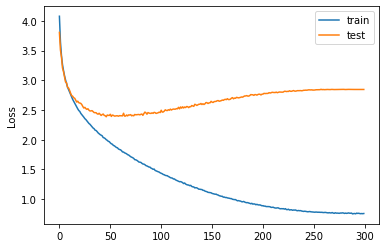

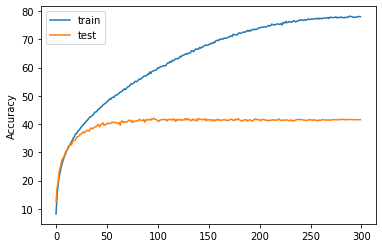


                                Experimenting on cifar100 Dataset 
                                patch:8,
                                sparse_att: True,
                                sparse_mlp: False,
                                num_layers: 4,
                                pos_embed: True,
                                seed: 147
                            
Files already downloaded and verified
Files already downloaded and verified
16 256
ViT Mixer : Channels per patch -> Initial:192 Final:256
[2, 4, 8, 16, 32, 64, 128, 256]
Sequence len: 16 ; Block size: 4
Channel dim: 256 num heads: 16
MLP dim: 256 ; Block size: 256
number of params:  2567524
Model Name: 01.3_ViT_PE_cifar100_patch8_l4_sAtt_mlp_s147
EXPERIMENT DONE... SKIPPING : 01.3_ViT_PE_cifar100_patch8_l4_sAtt_mlp_s147

                                Experimenting on cifar100 Dataset 
                                patch:8,
                                sparse_att: True,
                                sparse_

100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.55it/s]


[Train] 0 Loss: 4.111 | Acc: 7.774 3887/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.83it/s]


[Test] 0 Loss: 3.778 | Acc: 12.610 1261/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.63it/s]


[Train] 1 Loss: 3.658 | Acc: 14.308 7154/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.05it/s]


[Test] 1 Loss: 3.487 | Acc: 17.840 1784/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.40it/s]


[Train] 2 Loss: 3.436 | Acc: 18.256 9128/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.68it/s]


[Test] 2 Loss: 3.290 | Acc: 21.090 2109/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.54it/s]


[Train] 3 Loss: 3.280 | Acc: 21.056 10528/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.12it/s]


[Test] 3 Loss: 3.168 | Acc: 23.530 2353/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.49it/s]


[Train] 4 Loss: 3.167 | Acc: 22.856 11428/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.00it/s]


[Test] 4 Loss: 3.083 | Acc: 24.970 2497/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.58it/s]


[Train] 5 Loss: 3.067 | Acc: 24.850 12425/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.21it/s]


[Test] 5 Loss: 3.005 | Acc: 26.860 2686/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.80it/s]


[Train] 6 Loss: 2.987 | Acc: 26.424 13212/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.37it/s]


[Test] 6 Loss: 2.945 | Acc: 27.970 2797/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.31it/s]


[Train] 7 Loss: 2.928 | Acc: 27.634 13817/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.03it/s]


[Test] 7 Loss: 2.904 | Acc: 29.050 2905/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.23it/s]


[Train] 8 Loss: 2.869 | Acc: 28.756 14378/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.17it/s]


[Test] 8 Loss: 2.844 | Acc: 30.020 3002/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.60it/s]


[Train] 9 Loss: 2.823 | Acc: 29.640 14820/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.44it/s]


[Test] 9 Loss: 2.830 | Acc: 30.200 3020/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.69it/s]


[Train] 10 Loss: 2.774 | Acc: 30.542 15271/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.15it/s]


[Test] 10 Loss: 2.805 | Acc: 31.240 3124/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.34it/s]


[Train] 11 Loss: 2.728 | Acc: 31.672 15836/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.95it/s]


[Test] 11 Loss: 2.756 | Acc: 31.920 3192/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.42it/s]


[Train] 12 Loss: 2.692 | Acc: 32.190 16095/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.43it/s]


[Test] 12 Loss: 2.735 | Acc: 32.260 3226/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.66it/s]


[Train] 13 Loss: 2.648 | Acc: 33.038 16519/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.34it/s]


[Test] 13 Loss: 2.708 | Acc: 33.480 3348/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.57it/s]


[Train] 14 Loss: 2.609 | Acc: 33.840 16920/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.41it/s]


[Test] 14 Loss: 2.698 | Acc: 33.340 3334/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.61it/s]


[Train] 15 Loss: 2.581 | Acc: 34.564 17282/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.28it/s]


[Test] 15 Loss: 2.660 | Acc: 34.180 3418/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.43it/s]


[Train] 16 Loss: 2.545 | Acc: 35.190 17595/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.51it/s]


[Test] 16 Loss: 2.633 | Acc: 34.460 3446/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.36it/s]


[Train] 17 Loss: 2.512 | Acc: 35.784 17892/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.58it/s]


[Test] 17 Loss: 2.647 | Acc: 33.990 3399/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.52it/s]


[Train] 18 Loss: 2.480 | Acc: 36.524 18262/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.72it/s]


[Test] 18 Loss: 2.628 | Acc: 34.800 3480/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.62it/s]


[Train] 19 Loss: 2.449 | Acc: 37.150 18575/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.26it/s]


[Test] 19 Loss: 2.609 | Acc: 34.870 3487/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.29it/s]


[Train] 20 Loss: 2.427 | Acc: 37.800 18900/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.75it/s]


[Test] 20 Loss: 2.597 | Acc: 35.650 3565/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.49it/s]


[Train] 21 Loss: 2.402 | Acc: 38.132 19066/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.95it/s]


[Test] 21 Loss: 2.585 | Acc: 35.850 3585/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.51it/s]


[Train] 22 Loss: 2.379 | Acc: 38.784 19392/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.02it/s]


[Test] 22 Loss: 2.561 | Acc: 36.680 3668/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.39it/s]


[Train] 23 Loss: 2.348 | Acc: 39.072 19536/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.36it/s]


[Test] 23 Loss: 2.563 | Acc: 35.750 3575/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.62it/s]


[Train] 24 Loss: 2.328 | Acc: 39.682 19841/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.29it/s]


[Test] 24 Loss: 2.533 | Acc: 36.950 3695/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.54it/s]


[Train] 25 Loss: 2.300 | Acc: 40.126 20063/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.44it/s]


[Test] 25 Loss: 2.535 | Acc: 37.000 3700/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.58it/s]


[Train] 26 Loss: 2.278 | Acc: 40.698 20349/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.10it/s]


[Test] 26 Loss: 2.536 | Acc: 37.110 3711/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.54it/s]


[Train] 27 Loss: 2.259 | Acc: 41.068 20534/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.78it/s]


[Test] 27 Loss: 2.531 | Acc: 37.090 3709/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.55it/s]


[Train] 28 Loss: 2.240 | Acc: 41.460 20730/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.17it/s]


[Test] 28 Loss: 2.516 | Acc: 37.490 3749/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.57it/s]


[Train] 29 Loss: 2.217 | Acc: 42.028 21014/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.73it/s]


[Test] 29 Loss: 2.500 | Acc: 37.830 3783/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.46it/s]


[Train] 30 Loss: 2.194 | Acc: 42.688 21344/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.50it/s]


[Test] 30 Loss: 2.547 | Acc: 36.810 3681/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.61it/s]


[Train] 31 Loss: 2.169 | Acc: 43.008 21504/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.53it/s]


[Test] 31 Loss: 2.528 | Acc: 37.620 3762/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.64it/s]


[Train] 32 Loss: 2.156 | Acc: 43.378 21689/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.06it/s]


[Test] 32 Loss: 2.544 | Acc: 37.230 3723/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.54it/s]


[Train] 33 Loss: 2.138 | Acc: 43.880 21940/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.65it/s]


[Test] 33 Loss: 2.495 | Acc: 38.080 3808/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.54it/s]


[Train] 34 Loss: 2.113 | Acc: 44.196 22098/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.32it/s]


[Test] 34 Loss: 2.484 | Acc: 38.280 3828/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.56it/s]


[Train] 35 Loss: 2.098 | Acc: 44.566 22283/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.00it/s]


[Test] 35 Loss: 2.497 | Acc: 38.550 3855/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.34it/s]


[Train] 36 Loss: 2.083 | Acc: 45.102 22551/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.42it/s]


[Test] 36 Loss: 2.492 | Acc: 38.240 3824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.25it/s]


[Train] 37 Loss: 2.070 | Acc: 45.426 22713/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.56it/s]


[Test] 37 Loss: 2.467 | Acc: 38.620 3862/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.33it/s]


[Train] 38 Loss: 2.046 | Acc: 45.860 22930/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.30it/s]


[Test] 38 Loss: 2.480 | Acc: 38.840 3884/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.20it/s]


[Train] 39 Loss: 2.026 | Acc: 46.176 23088/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.70it/s]


[Test] 39 Loss: 2.472 | Acc: 38.760 3876/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.32it/s]


[Train] 40 Loss: 2.016 | Acc: 46.378 23189/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.49it/s]


[Test] 40 Loss: 2.474 | Acc: 38.760 3876/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.28it/s]


[Train] 41 Loss: 1.996 | Acc: 46.624 23312/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.31it/s]


[Test] 41 Loss: 2.460 | Acc: 39.290 3929/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.51it/s]


[Train] 42 Loss: 1.986 | Acc: 47.006 23503/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.79it/s]


[Test] 42 Loss: 2.463 | Acc: 39.120 3912/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.50it/s]


[Train] 43 Loss: 1.970 | Acc: 47.458 23729/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.97it/s]


[Test] 43 Loss: 2.496 | Acc: 38.900 3890/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.46it/s]


[Train] 44 Loss: 1.946 | Acc: 47.892 23946/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.71it/s]


[Test] 44 Loss: 2.483 | Acc: 39.210 3921/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.47it/s]


[Train] 45 Loss: 1.943 | Acc: 47.580 23790/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.36it/s]


[Test] 45 Loss: 2.507 | Acc: 38.300 3830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.35it/s]


[Train] 46 Loss: 1.921 | Acc: 48.530 24265/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.94it/s]


[Test] 46 Loss: 2.459 | Acc: 39.230 3923/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.46it/s]


[Train] 47 Loss: 1.906 | Acc: 48.980 24490/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.47it/s]


[Test] 47 Loss: 2.461 | Acc: 39.830 3983/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.46it/s]


[Train] 48 Loss: 1.886 | Acc: 49.172 24586/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.04it/s]


[Test] 48 Loss: 2.474 | Acc: 39.260 3926/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.49it/s]


[Train] 49 Loss: 1.883 | Acc: 49.182 24591/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.83it/s]


[Test] 49 Loss: 2.475 | Acc: 39.480 3948/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.34it/s]


[Train] 50 Loss: 1.868 | Acc: 49.698 24849/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.63it/s]


[Test] 50 Loss: 2.508 | Acc: 38.930 3893/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.41it/s]


[Train] 51 Loss: 1.845 | Acc: 50.224 25112/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.37it/s]


[Test] 51 Loss: 2.469 | Acc: 39.320 3932/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.41it/s]


[Train] 52 Loss: 1.835 | Acc: 50.314 25157/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.03it/s]


[Test] 52 Loss: 2.477 | Acc: 39.500 3950/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.34it/s]


[Train] 53 Loss: 1.824 | Acc: 50.594 25297/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.78it/s]


[Test] 53 Loss: 2.473 | Acc: 39.200 3920/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.43it/s]


[Train] 54 Loss: 1.807 | Acc: 50.942 25471/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.96it/s]


[Test] 54 Loss: 2.472 | Acc: 40.240 4024/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.34it/s]


[Train] 55 Loss: 1.797 | Acc: 51.224 25612/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.38it/s]


[Test] 55 Loss: 2.471 | Acc: 39.820 3982/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.42it/s]


[Train] 56 Loss: 1.786 | Acc: 51.738 25869/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.20it/s]


[Test] 56 Loss: 2.474 | Acc: 40.200 4020/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.49it/s]


[Train] 57 Loss: 1.774 | Acc: 51.746 25873/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.30it/s]


[Test] 57 Loss: 2.469 | Acc: 40.030 4003/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.31it/s]


[Train] 58 Loss: 1.760 | Acc: 52.152 26076/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.40it/s]


[Test] 58 Loss: 2.471 | Acc: 40.210 4021/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.53it/s]


[Train] 59 Loss: 1.744 | Acc: 52.226 26113/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.07it/s]


[Test] 59 Loss: 2.466 | Acc: 40.200 4020/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.40it/s]


[Train] 60 Loss: 1.739 | Acc: 52.712 26356/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.44it/s]


[Test] 60 Loss: 2.481 | Acc: 39.790 3979/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.24it/s]


[Train] 61 Loss: 1.726 | Acc: 52.868 26434/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.90it/s]


[Test] 61 Loss: 2.475 | Acc: 40.420 4042/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.64it/s]


[Train] 62 Loss: 1.708 | Acc: 53.264 26632/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.79it/s]


[Test] 62 Loss: 2.487 | Acc: 40.040 4004/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.58it/s]


[Train] 63 Loss: 1.704 | Acc: 53.508 26754/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.76it/s]


[Test] 63 Loss: 2.514 | Acc: 39.290 3929/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.67it/s]


[Train] 64 Loss: 1.691 | Acc: 53.658 26829/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.09it/s]


[Test] 64 Loss: 2.492 | Acc: 40.420 4042/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.32it/s]


[Train] 65 Loss: 1.683 | Acc: 54.060 27030/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.34it/s]


[Test] 65 Loss: 2.488 | Acc: 39.530 3953/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.43it/s]


[Train] 66 Loss: 1.668 | Acc: 54.224 27112/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.50it/s]


[Test] 66 Loss: 2.493 | Acc: 40.130 4013/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.59it/s]


[Train] 67 Loss: 1.658 | Acc: 54.468 27234/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.55it/s]


[Test] 67 Loss: 2.493 | Acc: 40.070 4007/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.49it/s]


[Train] 68 Loss: 1.642 | Acc: 54.834 27417/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.57it/s]


[Test] 68 Loss: 2.489 | Acc: 40.550 4055/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.69it/s]


[Train] 69 Loss: 1.628 | Acc: 55.240 27620/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.33it/s]


[Test] 69 Loss: 2.485 | Acc: 40.850 4085/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.62it/s]


[Train] 70 Loss: 1.619 | Acc: 55.834 27917/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.25it/s]


[Test] 70 Loss: 2.493 | Acc: 40.160 4016/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.62it/s]


[Train] 71 Loss: 1.603 | Acc: 55.488 27744/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.20it/s]


[Test] 71 Loss: 2.489 | Acc: 40.430 4043/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.51it/s]


[Train] 72 Loss: 1.598 | Acc: 55.988 27994/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.29it/s]


[Test] 72 Loss: 2.496 | Acc: 40.170 4017/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.46it/s]


[Train] 73 Loss: 1.589 | Acc: 56.086 28043/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.78it/s]


[Test] 73 Loss: 2.512 | Acc: 40.510 4051/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.60it/s]


[Train] 74 Loss: 1.574 | Acc: 56.668 28334/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.33it/s]


[Test] 74 Loss: 2.507 | Acc: 40.230 4023/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.65it/s]


[Train] 75 Loss: 1.563 | Acc: 56.758 28379/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.41it/s]


[Test] 75 Loss: 2.513 | Acc: 40.200 4020/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.68it/s]


[Train] 76 Loss: 1.553 | Acc: 56.936 28468/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.33it/s]


[Test] 76 Loss: 2.495 | Acc: 40.760 4076/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.67it/s]


[Train] 77 Loss: 1.545 | Acc: 57.280 28640/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.83it/s]


[Test] 77 Loss: 2.516 | Acc: 40.200 4020/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.58it/s]


[Train] 78 Loss: 1.536 | Acc: 57.512 28756/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.51it/s]


[Test] 78 Loss: 2.530 | Acc: 39.930 3993/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.54it/s]


[Train] 79 Loss: 1.520 | Acc: 57.852 28926/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.97it/s]


[Test] 79 Loss: 2.511 | Acc: 40.590 4059/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.47it/s]


[Train] 80 Loss: 1.509 | Acc: 57.954 28977/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.79it/s]


[Test] 80 Loss: 2.521 | Acc: 40.370 4037/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.49it/s]


[Train] 81 Loss: 1.502 | Acc: 58.018 29009/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.34it/s]


[Test] 81 Loss: 2.523 | Acc: 40.680 4068/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.43it/s]


[Train] 82 Loss: 1.496 | Acc: 58.184 29092/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.39it/s]


[Test] 82 Loss: 2.543 | Acc: 40.480 4048/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.36it/s]


[Train] 83 Loss: 1.479 | Acc: 58.718 29359/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.77it/s]


[Test] 83 Loss: 2.538 | Acc: 40.490 4049/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.79it/s]


[Train] 84 Loss: 1.482 | Acc: 58.716 29358/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.22it/s]


[Test] 84 Loss: 2.579 | Acc: 40.060 4006/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.38it/s]


[Train] 85 Loss: 1.463 | Acc: 58.902 29451/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.26it/s]


[Test] 85 Loss: 2.544 | Acc: 40.810 4081/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.44it/s]


[Train] 86 Loss: 1.461 | Acc: 59.540 29770/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.70it/s]


[Test] 86 Loss: 2.537 | Acc: 40.580 4058/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.46it/s]


[Train] 87 Loss: 1.443 | Acc: 59.770 29885/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.92it/s]


[Test] 87 Loss: 2.555 | Acc: 40.270 4027/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.38it/s]


[Train] 88 Loss: 1.430 | Acc: 60.078 30039/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.92it/s]


[Test] 88 Loss: 2.569 | Acc: 40.590 4059/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.42it/s]


[Train] 89 Loss: 1.426 | Acc: 60.060 30030/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.79it/s]


[Test] 89 Loss: 2.540 | Acc: 41.240 4124/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.28it/s]


[Train] 90 Loss: 1.422 | Acc: 60.258 30129/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.42it/s]


[Test] 90 Loss: 2.556 | Acc: 40.170 4017/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.47it/s]


[Train] 91 Loss: 1.404 | Acc: 60.684 30342/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.11it/s]


[Test] 91 Loss: 2.564 | Acc: 40.200 4020/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.30it/s]


[Train] 92 Loss: 1.403 | Acc: 60.668 30334/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.55it/s]


[Test] 92 Loss: 2.575 | Acc: 40.390 4039/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.58it/s]


[Train] 93 Loss: 1.396 | Acc: 60.792 30396/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.76it/s]


[Test] 93 Loss: 2.577 | Acc: 40.640 4064/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.34it/s]


[Train] 94 Loss: 1.381 | Acc: 61.374 30687/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.33it/s]


[Test] 94 Loss: 2.583 | Acc: 40.640 4064/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.51it/s]


[Train] 95 Loss: 1.370 | Acc: 61.544 30772/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.46it/s]


[Test] 95 Loss: 2.571 | Acc: 40.900 4090/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.43it/s]


[Train] 96 Loss: 1.371 | Acc: 61.332 30666/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.61it/s]


[Test] 96 Loss: 2.581 | Acc: 40.340 4034/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.41it/s]


[Train] 97 Loss: 1.361 | Acc: 61.620 30810/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.30it/s]


[Test] 97 Loss: 2.582 | Acc: 40.630 4063/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.36it/s]


[Train] 98 Loss: 1.354 | Acc: 61.822 30911/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.63it/s]


[Test] 98 Loss: 2.583 | Acc: 40.410 4041/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.30it/s]


[Train] 99 Loss: 1.343 | Acc: 62.136 31068/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.21it/s]


[Test] 99 Loss: 2.594 | Acc: 40.530 4053/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.42it/s]


[Train] 100 Loss: 1.331 | Acc: 62.390 31195/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.33it/s]


[Test] 100 Loss: 2.585 | Acc: 40.980 4098/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.21it/s]


[Train] 101 Loss: 1.323 | Acc: 62.538 31269/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.08it/s]


[Test] 101 Loss: 2.593 | Acc: 40.610 4061/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.28it/s]


[Train] 102 Loss: 1.311 | Acc: 62.630 31315/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.86it/s]


[Test] 102 Loss: 2.591 | Acc: 40.940 4094/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.25it/s]


[Train] 103 Loss: 1.303 | Acc: 63.244 31622/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.74it/s]


[Test] 103 Loss: 2.603 | Acc: 40.620 4062/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.18it/s]


[Train] 104 Loss: 1.295 | Acc: 63.378 31689/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.21it/s]


[Test] 104 Loss: 2.628 | Acc: 40.370 4037/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.26it/s]


[Train] 105 Loss: 1.293 | Acc: 63.468 31734/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.97it/s]


[Test] 105 Loss: 2.608 | Acc: 40.500 4050/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.45it/s]


[Train] 106 Loss: 1.283 | Acc: 63.718 31859/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.18it/s]


[Test] 106 Loss: 2.605 | Acc: 40.880 4088/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.40it/s]


[Train] 107 Loss: 1.275 | Acc: 63.572 31786/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.80it/s]


[Test] 107 Loss: 2.626 | Acc: 40.460 4046/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.50it/s]


[Train] 108 Loss: 1.270 | Acc: 63.864 31932/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.10it/s]


[Test] 108 Loss: 2.632 | Acc: 40.390 4039/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.42it/s]


[Train] 109 Loss: 1.254 | Acc: 64.360 32180/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.77it/s]


[Test] 109 Loss: 2.626 | Acc: 40.660 4066/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.49it/s]


[Train] 110 Loss: 1.250 | Acc: 64.340 32170/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.70it/s]


[Test] 110 Loss: 2.625 | Acc: 40.870 4087/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.24it/s]


[Train] 111 Loss: 1.247 | Acc: 64.420 32210/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.04it/s]


[Test] 111 Loss: 2.649 | Acc: 40.470 4047/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.19it/s]


[Train] 112 Loss: 1.233 | Acc: 64.732 32366/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.43it/s]


[Test] 112 Loss: 2.646 | Acc: 40.650 4065/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.28it/s]


[Train] 113 Loss: 1.225 | Acc: 65.016 32508/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.98it/s]


[Test] 113 Loss: 2.645 | Acc: 40.610 4061/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.34it/s]


[Train] 114 Loss: 1.219 | Acc: 65.468 32734/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.91it/s]


[Test] 114 Loss: 2.651 | Acc: 40.450 4045/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.20it/s]


[Train] 115 Loss: 1.215 | Acc: 65.142 32571/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.27it/s]


[Test] 115 Loss: 2.678 | Acc: 40.540 4054/10000


100%|███████████████████████████████████████████████████| 391/391 [00:10<00:00, 36.22it/s]


[Train] 116 Loss: 1.208 | Acc: 65.678 32839/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.63it/s]


[Test] 116 Loss: 2.652 | Acc: 40.480 4048/10000


 36%|██████████████████▍                                | 141/391 [00:03<00:06, 37.36it/s]

In [ ]:
### Automate the benchmark
###### for c10 / c100

not_working = [
    (1, False, False, 4),
    (1, False, False, 8),
    (1, False, False, 12),
    (1, False, True, 4),
    (1, False, True, 8),
    (1, False, True, 12),

    (1, True, False, 12),
    (1, True, True, 12),
]

cuda_idx = 1
for dataset in ['cifar100']:
    for seed in [147, 258, 369]:
        for nlayers in [4, 8, 12]:
            for patch_size in [8, 4, 2, 1]:
                for sparse_attention in [False, True]:
                    for sparse_mlp in [False, True]:
                        for PE in [True, False]:

                            print(f'''
                                Experimenting on {dataset} Dataset 
                                patch:{patch_size},
                                sparse_att: {sparse_attention},
                                sparse_mlp: {sparse_mlp},
                                num_layers: {nlayers},
                                pos_embed: {PE},
                                seed: {seed}
                            ''')

                        ### check if config is in not_working case
                            exit = False
                            for nw in not_working:
                                if patch_size==nw[0] and \
                                    sparse_attention==nw[1] and \
                                    sparse_mlp==nw[2] and\
                                    nlayers==nw[3]:

                                    exit=True
                                    break
                            if exit:
                                print(f'Exiting as the config is in NOT WORKING')
                                continue


                            benchmark(dataset=dataset, 
                                      patch_size=patch_size, 
                                      num_layers=nlayers, 
                                      SEED=seed, 
                                      sparse_att=sparse_attention, sparse_mlp=sparse_mlp, 
                                      pos_emb=PE,
                                      cuda=cuda_idx
                                     )

In [ ]:
asdasdasd

In [ ]:
## Use mixing 

In [ ]:
### TODO: Experiments
'''
1. Sparse Attention
2. Sparse MLP
3. Sparse Att + MLP

Datasets:
A. Cifar-10/100 -> 4x4 vs 2x2 vs 1x1 patch
B. Tiny-Imagenet -> 16x16 vs 4x4 vs 2x2 patch
'''

In [ ]:
'''
## Cifar 10/100

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[8, 8], hidden_channel=256, num_blocks=6, num_classes=200, block_seq_size=4, block_mlp_size=16)

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[4, 4], hidden_channel=128, num_blocks=3, num_classes=10, block_seq_size=8, block_mlp_size=128)

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[2, 2], hidden_channel=64, num_blocks=3, num_classes=10, block_seq_size=16, block_mlp_size=8)

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[1, 1], hidden_channel=64, num_blocks=3, num_classes=10, block_seq_size=32, block_mlp_size=8)

'''

In [ ]:
'''
vit_mixer = Mixer_ViT_Classifier((3, 64, 64), patch_size=[4, 4], hidden_channel=128, num_blocks=9, num_classes=200, block_seq_size=16, block_mlp_size=16)
Sequence len: 256 ; Block size: 16
Channel dim: 128 num heads: 8
MLP dim: 128 ; Block size: 16


vit_mixer = Mixer_ViT_Classifier((3, 64, 64), patch_size=[8, 8], hidden_channel=256, num_blocks=9, num_classes=200, block_seq_size=8, block_mlp_size=16)
Sequence len: 64 ; Block size: 16
Channel dim: 256 num heads: 16
MLP dim: 256 ; Block size: 16

vit_mixer = Mixer_ViT_Classifier((3, 64, 64), patch_size=[16, 16], hidden_channel=1024, num_blocks=9, num_classes=200, block_seq_size=4, block_mlp_size=32)
Sequence len: 16 ; Block size: 4
Channel dim: 1024 num heads: 32
MLP dim: 1024 ; Block size: 32
'''

### Automate the model creation

In [ ]:
img = 64
patch_size = [16, 8, 4, 2, 1]
expansion = [1024, 256, 128, 64, 64]

for i in range(len(patch_size)):
    ps, exp = patch_size[i], expansion[i]
    print(i, ps, exp)
    seq_len = (img//ps)**2
    print('seq:', seq_len)
    
    fact_seq = int(2**np.ceil(np.log2(np.sqrt(seq_len))))
    print(f'fact_seq: {fact_seq}')
    
    
    fact_mlp = int(2**np.ceil(np.log2(np.sqrt(exp))))
    print(f'fact_mlp: {fact_mlp}')